c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
C:\Users\Admin\AppData\Local\Temp\ipykernel_25324\2051169424.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dew_data.rename(columns={'dew': 'y'}, inplace=True)


Evaluating: changepoint_prior_scale=0.01, seasonality_prior_scale=0.1, seasonality_mode=additive


13:18:31 - cmdstanpy - INFO - Chain [1] start processing
13:18:31 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:18:31 - cmdstanpy - INFO - Chain [1] start processing
13:18:32 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:18:32 - cmdstanpy - INFO - Chain [1] start processing
13:18:32 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.603, RMSE: 3.659, MAE: 2.633

Evaluating: changepoint_prior_scale=0.01, seasonality_prior_scale=0.1, seasonality_mode=multiplicative


13:18:33 - cmdstanpy - INFO - Chain [1] start processing
13:18:34 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:18:34 - cmdstanpy - INFO - Chain [1] start processing
13:18:34 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:18:34 - cmdstanpy - INFO - Chain [1] start processing
13:18:35 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.610, RMSE: 3.635, MAE: 2.608

Evaluating: changepoint_prior_scale=0.01, seasonality_prior_scale=1.1, seasonality_mode=additive


13:18:36 - cmdstanpy - INFO - Chain [1] start processing
13:18:36 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:18:37 - cmdstanpy - INFO - Chain [1] start processing
13:18:37 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:18:37 - cmdstanpy - INFO - Chain [1] start processing
13:18:37 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.601, RMSE: 3.666, MAE: 2.642

Evaluating: changepoint_prior_scale=0.01, seasonality_prior_scale=1.1, seasonality_mode=multiplicative


13:18:38 - cmdstanpy - INFO - Chain [1] start processing
13:18:39 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:18:39 - cmdstanpy - INFO - Chain [1] start processing
13:18:39 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:18:39 - cmdstanpy - INFO - Chain [1] start processing
13:18:40 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.608, RMSE: 3.640, MAE: 2.615

Evaluating: changepoint_prior_scale=0.01, seasonality_prior_scale=2.1, seasonality_mode=additive


13:18:41 - cmdstanpy - INFO - Chain [1] start processing
13:18:42 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:18:42 - cmdstanpy - INFO - Chain [1] start processing
13:18:42 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:18:42 - cmdstanpy - INFO - Chain [1] start processing
13:18:43 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.603, RMSE: 3.661, MAE: 2.637

Evaluating: changepoint_prior_scale=0.01, seasonality_prior_scale=2.1, seasonality_mode=multiplicative


13:18:44 - cmdstanpy - INFO - Chain [1] start processing
13:18:44 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:18:45 - cmdstanpy - INFO - Chain [1] start processing
13:18:45 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:18:45 - cmdstanpy - INFO - Chain [1] start processing
13:18:45 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.608, RMSE: 3.643, MAE: 2.622

Evaluating: changepoint_prior_scale=0.01, seasonality_prior_scale=3.1, seasonality_mode=additive


13:18:47 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:18:47 - cmdstanpy - INFO - Chain [1] start processing
13:18:47 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:18:47 - cmdstanpy - INFO - Chain [1] start processing
13:18:47 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared

R² Score: 0.601, RMSE: 3.666, MAE: 2.645

Evaluating: changepoint_prior_scale=0.01, seasonality_prior_scale=3.1, seasonality_mode=multiplicative


13:18:49 - cmdstanpy - INFO - Chain [1] start processing
13:18:49 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:18:49 - cmdstanpy - INFO - Chain [1] start processing
13:18:49 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:18:50 - cmdstanpy - INFO - Chain [1] start processing
13:18:50 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.608, RMSE: 3.641, MAE: 2.620

Evaluating: changepoint_prior_scale=0.01, seasonality_prior_scale=4.1, seasonality_mode=additive


13:18:51 - cmdstanpy - INFO - Chain [1] start processing
13:18:51 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:18:51 - cmdstanpy - INFO - Chain [1] start processing
13:18:52 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:18:52 - cmdstanpy - INFO - Chain [1] start processing
13:18:52 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.603, RMSE: 3.661, MAE: 2.635

Evaluating: changepoint_prior_scale=0.01, seasonality_prior_scale=4.1, seasonality_mode=multiplicative


13:18:53 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:18:54 - cmdstanpy - INFO - Chain [1] start processing
13:18:54 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:18:54 - cmdstanpy - INFO - Chain [1] start processing
13:18:54 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared

R² Score: 0.607, RMSE: 3.645, MAE: 2.627

Evaluating: changepoint_prior_scale=0.01, seasonality_prior_scale=5.1, seasonality_mode=additive


13:18:55 - cmdstanpy - INFO - Chain [1] start processing
13:18:55 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:18:56 - cmdstanpy - INFO - Chain [1] start processing
13:18:56 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:18:56 - cmdstanpy - INFO - Chain [1] start processing
13:18:56 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.603, RMSE: 3.659, MAE: 2.633

Evaluating: changepoint_prior_scale=0.01, seasonality_prior_scale=5.1, seasonality_mode=multiplicative


13:18:57 - cmdstanpy - INFO - Chain [1] start processing
13:18:57 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:18:58 - cmdstanpy - INFO - Chain [1] start processing
13:18:58 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:18:58 - cmdstanpy - INFO - Chain [1] start processing
13:18:58 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.608, RMSE: 3.640, MAE: 2.616

Evaluating: changepoint_prior_scale=0.01, seasonality_prior_scale=6.1, seasonality_mode=additive


13:18:59 - cmdstanpy - INFO - Chain [1] start processing
13:18:59 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:00 - cmdstanpy - INFO - Chain [1] start processing
13:19:00 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:00 - cmdstanpy - INFO - Chain [1] start processing
13:19:00 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.602, RMSE: 3.664, MAE: 2.642

Evaluating: changepoint_prior_scale=0.01, seasonality_prior_scale=6.1, seasonality_mode=multiplicative


13:19:02 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:02 - cmdstanpy - INFO - Chain [1] start processing
13:19:02 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:02 - cmdstanpy - INFO - Chain [1] start processing
13:19:02 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared

R² Score: 0.607, RMSE: 3.647, MAE: 2.625

Evaluating: changepoint_prior_scale=0.01, seasonality_prior_scale=7.1, seasonality_mode=additive


13:19:03 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:04 - cmdstanpy - INFO - Chain [1] start processing
13:19:04 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:04 - cmdstanpy - INFO - Chain [1] start processing
13:19:04 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared

R² Score: 0.601, RMSE: 3.666, MAE: 2.642

Evaluating: changepoint_prior_scale=0.01, seasonality_prior_scale=7.1, seasonality_mode=multiplicative


13:19:05 - cmdstanpy - INFO - Chain [1] start processing
13:19:06 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:06 - cmdstanpy - INFO - Chain [1] start processing
13:19:06 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:06 - cmdstanpy - INFO - Chain [1] start processing
13:19:06 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.609, RMSE: 3.639, MAE: 2.615

Evaluating: changepoint_prior_scale=0.01, seasonality_prior_scale=8.1, seasonality_mode=additive


13:19:07 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:08 - cmdstanpy - INFO - Chain [1] start processing
13:19:08 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:08 - cmdstanpy - INFO - Chain [1] start processing
13:19:08 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared

R² Score: 0.603, RMSE: 3.660, MAE: 2.635

Evaluating: changepoint_prior_scale=0.01, seasonality_prior_scale=8.1, seasonality_mode=multiplicative


13:19:09 - cmdstanpy - INFO - Chain [1] start processing
13:19:10 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:10 - cmdstanpy - INFO - Chain [1] start processing
13:19:10 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:10 - cmdstanpy - INFO - Chain [1] start processing
13:19:10 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.608, RMSE: 3.642, MAE: 2.619

Evaluating: changepoint_prior_scale=0.01, seasonality_prior_scale=9.1, seasonality_mode=additive


13:19:12 - cmdstanpy - INFO - Chain [1] start processing
13:19:12 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:12 - cmdstanpy - INFO - Chain [1] start processing
13:19:12 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:13 - cmdstanpy - INFO - Chain [1] start processing
13:19:13 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.604, RMSE: 3.658, MAE: 2.632

Evaluating: changepoint_prior_scale=0.01, seasonality_prior_scale=9.1, seasonality_mode=multiplicative


13:19:14 - cmdstanpy - INFO - Chain [1] start processing
13:19:14 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:14 - cmdstanpy - INFO - Chain [1] start processing
13:19:14 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:15 - cmdstanpy - INFO - Chain [1] start processing
13:19:15 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.607, RMSE: 3.644, MAE: 2.621

Evaluating: changepoint_prior_scale=0.01, seasonality_prior_scale=10.1, seasonality_mode=additive


13:19:16 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:16 - cmdstanpy - INFO - Chain [1] start processing
13:19:16 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:17 - cmdstanpy - INFO - Chain [1] start processing
13:19:17 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared

R² Score: 0.602, RMSE: 3.662, MAE: 2.638

Evaluating: changepoint_prior_scale=0.01, seasonality_prior_scale=10.1, seasonality_mode=multiplicative


13:19:18 - cmdstanpy - INFO - Chain [1] start processing
13:19:18 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:18 - cmdstanpy - INFO - Chain [1] start processing
13:19:18 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:19 - cmdstanpy - INFO - Chain [1] start processing
13:19:19 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.608, RMSE: 3.639, MAE: 2.616

Evaluating: changepoint_prior_scale=0.02, seasonality_prior_scale=0.1, seasonality_mode=additive


13:19:20 - cmdstanpy - INFO - Chain [1] start processing
13:19:20 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:20 - cmdstanpy - INFO - Chain [1] start processing
13:19:20 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:21 - cmdstanpy - INFO - Chain [1] start processing
13:19:21 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.603, RMSE: 3.663, MAE: 2.646

Evaluating: changepoint_prior_scale=0.02, seasonality_prior_scale=0.1, seasonality_mode=multiplicative


13:19:22 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:22 - cmdstanpy - INFO - Chain [1] start processing
13:19:22 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:23 - cmdstanpy - INFO - Chain [1] start processing
13:19:23 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared

R² Score: 0.606, RMSE: 3.650, MAE: 2.635

Evaluating: changepoint_prior_scale=0.02, seasonality_prior_scale=1.1, seasonality_mode=additive


13:19:24 - cmdstanpy - INFO - Chain [1] start processing
13:19:24 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:24 - cmdstanpy - INFO - Chain [1] start processing
13:19:24 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:25 - cmdstanpy - INFO - Chain [1] start processing
13:19:25 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.602, RMSE: 3.665, MAE: 2.647

Evaluating: changepoint_prior_scale=0.02, seasonality_prior_scale=1.1, seasonality_mode=multiplicative


13:19:26 - cmdstanpy - INFO - Chain [1] start processing
13:19:26 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:26 - cmdstanpy - INFO - Chain [1] start processing
13:19:26 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:27 - cmdstanpy - INFO - Chain [1] start processing
13:19:27 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.607, RMSE: 3.649, MAE: 2.632

Evaluating: changepoint_prior_scale=0.02, seasonality_prior_scale=2.1, seasonality_mode=additive


13:19:28 - cmdstanpy - INFO - Chain [1] start processing
13:19:28 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:28 - cmdstanpy - INFO - Chain [1] start processing
13:19:28 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:29 - cmdstanpy - INFO - Chain [1] start processing
13:19:29 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.603, RMSE: 3.664, MAE: 2.644

Evaluating: changepoint_prior_scale=0.02, seasonality_prior_scale=2.1, seasonality_mode=multiplicative


13:19:30 - cmdstanpy - INFO - Chain [1] start processing
13:19:30 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:30 - cmdstanpy - INFO - Chain [1] start processing
13:19:31 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:31 - cmdstanpy - INFO - Chain [1] start processing
13:19:31 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.606, RMSE: 3.651, MAE: 2.635

Evaluating: changepoint_prior_scale=0.02, seasonality_prior_scale=3.1, seasonality_mode=additive


13:19:32 - cmdstanpy - INFO - Chain [1] start processing
13:19:32 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:32 - cmdstanpy - INFO - Chain [1] start processing
13:19:32 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:33 - cmdstanpy - INFO - Chain [1] start processing
13:19:33 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.603, RMSE: 3.663, MAE: 2.644

Evaluating: changepoint_prior_scale=0.02, seasonality_prior_scale=3.1, seasonality_mode=multiplicative


13:19:34 - cmdstanpy - INFO - Chain [1] start processing
13:19:34 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:34 - cmdstanpy - INFO - Chain [1] start processing
13:19:34 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:35 - cmdstanpy - INFO - Chain [1] start processing
13:19:35 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.606, RMSE: 3.654, MAE: 2.637

Evaluating: changepoint_prior_scale=0.02, seasonality_prior_scale=4.1, seasonality_mode=additive


13:19:36 - cmdstanpy - INFO - Chain [1] start processing
13:19:36 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:36 - cmdstanpy - INFO - Chain [1] start processing
13:19:36 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:37 - cmdstanpy - INFO - Chain [1] start processing
13:19:37 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.603, RMSE: 3.661, MAE: 2.642

Evaluating: changepoint_prior_scale=0.02, seasonality_prior_scale=4.1, seasonality_mode=multiplicative


13:19:38 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:38 - cmdstanpy - INFO - Chain [1] start processing
13:19:38 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:39 - cmdstanpy - INFO - Chain [1] start processing
13:19:39 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared

R² Score: 0.605, RMSE: 3.655, MAE: 2.642

Evaluating: changepoint_prior_scale=0.02, seasonality_prior_scale=5.1, seasonality_mode=additive


13:19:40 - cmdstanpy - INFO - Chain [1] start processing
13:19:40 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:40 - cmdstanpy - INFO - Chain [1] start processing
13:19:40 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:41 - cmdstanpy - INFO - Chain [1] start processing
13:19:41 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.602, RMSE: 3.668, MAE: 2.650

Evaluating: changepoint_prior_scale=0.02, seasonality_prior_scale=5.1, seasonality_mode=multiplicative


13:19:42 - cmdstanpy - INFO - Chain [1] start processing
13:19:42 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:42 - cmdstanpy - INFO - Chain [1] start processing
13:19:42 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:43 - cmdstanpy - INFO - Chain [1] start processing
13:19:43 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.606, RMSE: 3.651, MAE: 2.635

Evaluating: changepoint_prior_scale=0.02, seasonality_prior_scale=6.1, seasonality_mode=additive


13:19:44 - cmdstanpy - INFO - Chain [1] start processing
13:19:44 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:44 - cmdstanpy - INFO - Chain [1] start processing
13:19:44 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:45 - cmdstanpy - INFO - Chain [1] start processing
13:19:45 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.602, RMSE: 3.667, MAE: 2.651

Evaluating: changepoint_prior_scale=0.02, seasonality_prior_scale=6.1, seasonality_mode=multiplicative


13:19:46 - cmdstanpy - INFO - Chain [1] start processing
13:19:46 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:46 - cmdstanpy - INFO - Chain [1] start processing
13:19:46 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:47 - cmdstanpy - INFO - Chain [1] start processing
13:19:47 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.607, RMSE: 3.648, MAE: 2.630

Evaluating: changepoint_prior_scale=0.02, seasonality_prior_scale=7.1, seasonality_mode=additive


13:19:48 - cmdstanpy - INFO - Chain [1] start processing
13:19:48 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:48 - cmdstanpy - INFO - Chain [1] start processing
13:19:48 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:49 - cmdstanpy - INFO - Chain [1] start processing
13:19:49 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.602, RMSE: 3.664, MAE: 2.645

Evaluating: changepoint_prior_scale=0.02, seasonality_prior_scale=7.1, seasonality_mode=multiplicative


13:19:50 - cmdstanpy - INFO - Chain [1] start processing
13:19:50 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:50 - cmdstanpy - INFO - Chain [1] start processing
13:19:50 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:51 - cmdstanpy - INFO - Chain [1] start processing
13:19:51 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.606, RMSE: 3.650, MAE: 2.635

Evaluating: changepoint_prior_scale=0.02, seasonality_prior_scale=8.1, seasonality_mode=additive


13:19:52 - cmdstanpy - INFO - Chain [1] start processing
13:19:52 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:52 - cmdstanpy - INFO - Chain [1] start processing
13:19:52 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:53 - cmdstanpy - INFO - Chain [1] start processing
13:19:53 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.601, RMSE: 3.668, MAE: 2.651

Evaluating: changepoint_prior_scale=0.02, seasonality_prior_scale=8.1, seasonality_mode=multiplicative


13:19:54 - cmdstanpy - INFO - Chain [1] start processing
13:19:54 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:54 - cmdstanpy - INFO - Chain [1] start processing
13:19:54 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:55 - cmdstanpy - INFO - Chain [1] start processing
13:19:55 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.608, RMSE: 3.645, MAE: 2.626

Evaluating: changepoint_prior_scale=0.02, seasonality_prior_scale=9.1, seasonality_mode=additive


13:19:56 - cmdstanpy - INFO - Chain [1] start processing
13:19:56 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:56 - cmdstanpy - INFO - Chain [1] start processing
13:19:56 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:57 - cmdstanpy - INFO - Chain [1] start processing
13:19:57 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.602, RMSE: 3.665, MAE: 2.645

Evaluating: changepoint_prior_scale=0.02, seasonality_prior_scale=9.1, seasonality_mode=multiplicative


13:19:58 - cmdstanpy - INFO - Chain [1] start processing
13:19:58 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:58 - cmdstanpy - INFO - Chain [1] start processing
13:19:58 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:19:59 - cmdstanpy - INFO - Chain [1] start processing
13:19:59 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.606, RMSE: 3.650, MAE: 2.634

Evaluating: changepoint_prior_scale=0.02, seasonality_prior_scale=10.1, seasonality_mode=additive


13:20:00 - cmdstanpy - INFO - Chain [1] start processing
13:20:00 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:00 - cmdstanpy - INFO - Chain [1] start processing
13:20:00 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:01 - cmdstanpy - INFO - Chain [1] start processing
13:20:01 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.603, RMSE: 3.665, MAE: 2.647

Evaluating: changepoint_prior_scale=0.02, seasonality_prior_scale=10.1, seasonality_mode=multiplicative


13:20:02 - cmdstanpy - INFO - Chain [1] start processing
13:20:02 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:02 - cmdstanpy - INFO - Chain [1] start processing
13:20:02 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:03 - cmdstanpy - INFO - Chain [1] start processing
13:20:03 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.607, RMSE: 3.650, MAE: 2.633

Evaluating: changepoint_prior_scale=0.03, seasonality_prior_scale=0.1, seasonality_mode=additive


13:20:04 - cmdstanpy - INFO - Chain [1] start processing
13:20:04 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:04 - cmdstanpy - INFO - Chain [1] start processing
13:20:05 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:05 - cmdstanpy - INFO - Chain [1] start processing
13:20:05 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.602, RMSE: 3.667, MAE: 2.655

Evaluating: changepoint_prior_scale=0.03, seasonality_prior_scale=0.1, seasonality_mode=multiplicative


13:20:06 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:06 - cmdstanpy - INFO - Chain [1] start processing
13:20:07 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:07 - cmdstanpy - INFO - Chain [1] start processing
13:20:07 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared

R² Score: 0.606, RMSE: 3.655, MAE: 2.640

Evaluating: changepoint_prior_scale=0.03, seasonality_prior_scale=1.1, seasonality_mode=additive


13:20:08 - cmdstanpy - INFO - Chain [1] start processing
13:20:08 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:08 - cmdstanpy - INFO - Chain [1] start processing
13:20:09 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:09 - cmdstanpy - INFO - Chain [1] start processing
13:20:09 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.604, RMSE: 3.660, MAE: 2.645

Evaluating: changepoint_prior_scale=0.03, seasonality_prior_scale=1.1, seasonality_mode=multiplicative


13:20:10 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:10 - cmdstanpy - INFO - Chain [1] start processing
13:20:11 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:11 - cmdstanpy - INFO - Chain [1] start processing
13:20:11 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared

R² Score: 0.605, RMSE: 3.655, MAE: 2.638

Evaluating: changepoint_prior_scale=0.03, seasonality_prior_scale=2.1, seasonality_mode=additive


13:20:12 - cmdstanpy - INFO - Chain [1] start processing
13:20:12 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:13 - cmdstanpy - INFO - Chain [1] start processing
13:20:13 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:13 - cmdstanpy - INFO - Chain [1] start processing
13:20:13 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.603, RMSE: 3.662, MAE: 2.649

Evaluating: changepoint_prior_scale=0.03, seasonality_prior_scale=2.1, seasonality_mode=multiplicative


13:20:14 - cmdstanpy - INFO - Chain [1] start processing
13:20:14 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:15 - cmdstanpy - INFO - Chain [1] start processing
13:20:15 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:15 - cmdstanpy - INFO - Chain [1] start processing
13:20:15 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.604, RMSE: 3.659, MAE: 2.645

Evaluating: changepoint_prior_scale=0.03, seasonality_prior_scale=3.1, seasonality_mode=additive


13:20:17 - cmdstanpy - INFO - Chain [1] start processing
13:20:17 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:17 - cmdstanpy - INFO - Chain [1] start processing
13:20:17 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:18 - cmdstanpy - INFO - Chain [1] start processing
13:20:18 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.604, RMSE: 3.661, MAE: 2.647

Evaluating: changepoint_prior_scale=0.03, seasonality_prior_scale=3.1, seasonality_mode=multiplicative


13:20:19 - cmdstanpy - INFO - Chain [1] start processing
13:20:19 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:20 - cmdstanpy - INFO - Chain [1] start processing
13:20:20 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:20 - cmdstanpy - INFO - Chain [1] start processing
13:20:20 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.605, RMSE: 3.656, MAE: 2.641

Evaluating: changepoint_prior_scale=0.03, seasonality_prior_scale=4.1, seasonality_mode=additive


13:20:21 - cmdstanpy - INFO - Chain [1] start processing
13:20:21 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:21 - cmdstanpy - INFO - Chain [1] start processing
13:20:22 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:22 - cmdstanpy - INFO - Chain [1] start processing
13:20:22 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.603, RMSE: 3.664, MAE: 2.648

Evaluating: changepoint_prior_scale=0.03, seasonality_prior_scale=4.1, seasonality_mode=multiplicative


13:20:23 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:23 - cmdstanpy - INFO - Chain [1] start processing
13:20:24 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:24 - cmdstanpy - INFO - Chain [1] start processing
13:20:24 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared

R² Score: 0.605, RMSE: 3.656, MAE: 2.641

Evaluating: changepoint_prior_scale=0.03, seasonality_prior_scale=5.1, seasonality_mode=additive


13:20:25 - cmdstanpy - INFO - Chain [1] start processing
13:20:25 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:26 - cmdstanpy - INFO - Chain [1] start processing
13:20:26 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:26 - cmdstanpy - INFO - Chain [1] start processing
13:20:26 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.603, RMSE: 3.665, MAE: 2.650

Evaluating: changepoint_prior_scale=0.03, seasonality_prior_scale=5.1, seasonality_mode=multiplicative


13:20:27 - cmdstanpy - INFO - Chain [1] start processing
13:20:27 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:28 - cmdstanpy - INFO - Chain [1] start processing
13:20:28 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:28 - cmdstanpy - INFO - Chain [1] start processing
13:20:28 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.606, RMSE: 3.654, MAE: 2.637

Evaluating: changepoint_prior_scale=0.03, seasonality_prior_scale=6.1, seasonality_mode=additive


13:20:29 - cmdstanpy - INFO - Chain [1] start processing
13:20:30 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:30 - cmdstanpy - INFO - Chain [1] start processing
13:20:30 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:30 - cmdstanpy - INFO - Chain [1] start processing
13:20:30 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.604, RMSE: 3.661, MAE: 2.645

Evaluating: changepoint_prior_scale=0.03, seasonality_prior_scale=6.1, seasonality_mode=multiplicative


13:20:32 - cmdstanpy - INFO - Chain [1] start processing
13:20:32 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:32 - cmdstanpy - INFO - Chain [1] start processing
13:20:32 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:32 - cmdstanpy - INFO - Chain [1] start processing
13:20:32 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.604, RMSE: 3.660, MAE: 2.645

Evaluating: changepoint_prior_scale=0.03, seasonality_prior_scale=7.1, seasonality_mode=additive


13:20:34 - cmdstanpy - INFO - Chain [1] start processing
13:20:34 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:34 - cmdstanpy - INFO - Chain [1] start processing
13:20:34 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:34 - cmdstanpy - INFO - Chain [1] start processing
13:20:34 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.603, RMSE: 3.662, MAE: 2.648

Evaluating: changepoint_prior_scale=0.03, seasonality_prior_scale=7.1, seasonality_mode=multiplicative


13:20:36 - cmdstanpy - INFO - Chain [1] start processing
13:20:36 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:36 - cmdstanpy - INFO - Chain [1] start processing
13:20:37 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:37 - cmdstanpy - INFO - Chain [1] start processing
13:20:37 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.606, RMSE: 3.652, MAE: 2.634

Evaluating: changepoint_prior_scale=0.03, seasonality_prior_scale=8.1, seasonality_mode=additive


13:20:39 - cmdstanpy - INFO - Chain [1] start processing
13:20:39 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:39 - cmdstanpy - INFO - Chain [1] start processing
13:20:39 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:40 - cmdstanpy - INFO - Chain [1] start processing
13:20:40 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.604, RMSE: 3.660, MAE: 2.647

Evaluating: changepoint_prior_scale=0.03, seasonality_prior_scale=8.1, seasonality_mode=multiplicative


13:20:41 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:41 - cmdstanpy - INFO - Chain [1] start processing
13:20:41 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:42 - cmdstanpy - INFO - Chain [1] start processing
13:20:42 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared

R² Score: 0.605, RMSE: 3.657, MAE: 2.642

Evaluating: changepoint_prior_scale=0.03, seasonality_prior_scale=9.1, seasonality_mode=additive


13:20:43 - cmdstanpy - INFO - Chain [1] start processing
13:20:43 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:44 - cmdstanpy - INFO - Chain [1] start processing
13:20:44 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:44 - cmdstanpy - INFO - Chain [1] start processing
13:20:44 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.603, RMSE: 3.663, MAE: 2.650

Evaluating: changepoint_prior_scale=0.03, seasonality_prior_scale=9.1, seasonality_mode=multiplicative


13:20:45 - cmdstanpy - INFO - Chain [1] start processing
13:20:46 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:46 - cmdstanpy - INFO - Chain [1] start processing
13:20:46 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:46 - cmdstanpy - INFO - Chain [1] start processing
13:20:47 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.606, RMSE: 3.654, MAE: 2.637

Evaluating: changepoint_prior_scale=0.03, seasonality_prior_scale=10.1, seasonality_mode=additive


13:20:48 - cmdstanpy - INFO - Chain [1] start processing
13:20:48 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:48 - cmdstanpy - INFO - Chain [1] start processing
13:20:48 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:49 - cmdstanpy - INFO - Chain [1] start processing
13:20:49 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.603, RMSE: 3.664, MAE: 2.649

Evaluating: changepoint_prior_scale=0.03, seasonality_prior_scale=10.1, seasonality_mode=multiplicative


13:20:50 - cmdstanpy - INFO - Chain [1] start processing
13:20:50 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:50 - cmdstanpy - INFO - Chain [1] start processing
13:20:50 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:51 - cmdstanpy - INFO - Chain [1] start processing
13:20:51 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.605, RMSE: 3.658, MAE: 2.642

Evaluating: changepoint_prior_scale=0.04, seasonality_prior_scale=0.1, seasonality_mode=additive


13:20:52 - cmdstanpy - INFO - Chain [1] start processing
13:20:52 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:52 - cmdstanpy - INFO - Chain [1] start processing
13:20:52 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:53 - cmdstanpy - INFO - Chain [1] start processing
13:20:53 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.601, RMSE: 3.668, MAE: 2.655

Evaluating: changepoint_prior_scale=0.04, seasonality_prior_scale=0.1, seasonality_mode=multiplicative


13:20:54 - cmdstanpy - INFO - Chain [1] start processing
13:20:54 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:54 - cmdstanpy - INFO - Chain [1] start processing
13:20:55 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:55 - cmdstanpy - INFO - Chain [1] start processing
13:20:55 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.604, RMSE: 3.662, MAE: 2.651

Evaluating: changepoint_prior_scale=0.04, seasonality_prior_scale=1.1, seasonality_mode=additive


13:20:56 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:57 - cmdstanpy - INFO - Chain [1] start processing
13:20:57 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:57 - cmdstanpy - INFO - Chain [1] start processing
13:20:57 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared

R² Score: 0.598, RMSE: 3.682, MAE: 2.671

Evaluating: changepoint_prior_scale=0.04, seasonality_prior_scale=1.1, seasonality_mode=multiplicative


13:20:58 - cmdstanpy - INFO - Chain [1] start processing
13:20:59 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:59 - cmdstanpy - INFO - Chain [1] start processing
13:20:59 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:20:59 - cmdstanpy - INFO - Chain [1] start processing
13:21:00 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.604, RMSE: 3.662, MAE: 2.650

Evaluating: changepoint_prior_scale=0.04, seasonality_prior_scale=2.1, seasonality_mode=additive


13:21:01 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:01 - cmdstanpy - INFO - Chain [1] start processing
13:21:01 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:02 - cmdstanpy - INFO - Chain [1] start processing
13:21:02 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared

R² Score: 0.601, RMSE: 3.669, MAE: 2.656

Evaluating: changepoint_prior_scale=0.04, seasonality_prior_scale=2.1, seasonality_mode=multiplicative


13:21:03 - cmdstanpy - INFO - Chain [1] start processing
13:21:03 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:03 - cmdstanpy - INFO - Chain [1] start processing
13:21:03 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:04 - cmdstanpy - INFO - Chain [1] start processing
13:21:04 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.604, RMSE: 3.661, MAE: 2.647

Evaluating: changepoint_prior_scale=0.04, seasonality_prior_scale=3.1, seasonality_mode=additive


13:21:05 - cmdstanpy - INFO - Chain [1] start processing
13:21:05 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:05 - cmdstanpy - INFO - Chain [1] start processing
13:21:05 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:06 - cmdstanpy - INFO - Chain [1] start processing
13:21:06 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.598, RMSE: 3.680, MAE: 2.668

Evaluating: changepoint_prior_scale=0.04, seasonality_prior_scale=3.1, seasonality_mode=multiplicative


13:21:07 - cmdstanpy - INFO - Chain [1] start processing
13:21:07 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:07 - cmdstanpy - INFO - Chain [1] start processing
13:21:08 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:08 - cmdstanpy - INFO - Chain [1] start processing
13:21:08 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.602, RMSE: 3.668, MAE: 2.659

Evaluating: changepoint_prior_scale=0.04, seasonality_prior_scale=4.1, seasonality_mode=additive


13:21:09 - cmdstanpy - INFO - Chain [1] start processing
13:21:10 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:10 - cmdstanpy - INFO - Chain [1] start processing
13:21:10 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:10 - cmdstanpy - INFO - Chain [1] start processing
13:21:10 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.601, RMSE: 3.670, MAE: 2.658

Evaluating: changepoint_prior_scale=0.04, seasonality_prior_scale=4.1, seasonality_mode=multiplicative


13:21:12 - cmdstanpy - INFO - Chain [1] start processing
13:21:12 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:12 - cmdstanpy - INFO - Chain [1] start processing
13:21:12 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:13 - cmdstanpy - INFO - Chain [1] start processing
13:21:13 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.603, RMSE: 3.668, MAE: 2.657

Evaluating: changepoint_prior_scale=0.04, seasonality_prior_scale=5.1, seasonality_mode=additive


13:21:14 - cmdstanpy - INFO - Chain [1] start processing
13:21:14 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:14 - cmdstanpy - INFO - Chain [1] start processing
13:21:14 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:15 - cmdstanpy - INFO - Chain [1] start processing
13:21:15 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.601, RMSE: 3.670, MAE: 2.657

Evaluating: changepoint_prior_scale=0.04, seasonality_prior_scale=5.1, seasonality_mode=multiplicative


13:21:16 - cmdstanpy - INFO - Chain [1] start processing
13:21:16 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:17 - cmdstanpy - INFO - Chain [1] start processing
13:21:17 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:17 - cmdstanpy - INFO - Chain [1] start processing
13:21:17 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.602, RMSE: 3.670, MAE: 2.661

Evaluating: changepoint_prior_scale=0.04, seasonality_prior_scale=6.1, seasonality_mode=additive


13:21:19 - cmdstanpy - INFO - Chain [1] start processing
13:21:19 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:19 - cmdstanpy - INFO - Chain [1] start processing
13:21:19 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:19 - cmdstanpy - INFO - Chain [1] start processing
13:21:20 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.601, RMSE: 3.671, MAE: 2.661

Evaluating: changepoint_prior_scale=0.04, seasonality_prior_scale=6.1, seasonality_mode=multiplicative


13:21:21 - cmdstanpy - INFO - Chain [1] start processing
13:21:21 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:21 - cmdstanpy - INFO - Chain [1] start processing
13:21:21 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:22 - cmdstanpy - INFO - Chain [1] start processing
13:21:22 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.604, RMSE: 3.663, MAE: 2.651

Evaluating: changepoint_prior_scale=0.04, seasonality_prior_scale=7.1, seasonality_mode=additive


13:21:23 - cmdstanpy - INFO - Chain [1] start processing
13:21:23 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:23 - cmdstanpy - INFO - Chain [1] start processing
13:21:23 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:24 - cmdstanpy - INFO - Chain [1] start processing
13:21:24 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.601, RMSE: 3.671, MAE: 2.659

Evaluating: changepoint_prior_scale=0.04, seasonality_prior_scale=7.1, seasonality_mode=multiplicative


13:21:25 - cmdstanpy - INFO - Chain [1] start processing
13:21:25 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:25 - cmdstanpy - INFO - Chain [1] start processing
13:21:25 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:26 - cmdstanpy - INFO - Chain [1] start processing
13:21:26 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.603, RMSE: 3.665, MAE: 2.654

Evaluating: changepoint_prior_scale=0.04, seasonality_prior_scale=8.1, seasonality_mode=additive


13:21:27 - cmdstanpy - INFO - Chain [1] start processing
13:21:27 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:28 - cmdstanpy - INFO - Chain [1] start processing
13:21:28 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:28 - cmdstanpy - INFO - Chain [1] start processing
13:21:28 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.599, RMSE: 3.676, MAE: 2.663

Evaluating: changepoint_prior_scale=0.04, seasonality_prior_scale=8.1, seasonality_mode=multiplicative


13:21:29 - cmdstanpy - INFO - Chain [1] start processing
13:21:29 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:30 - cmdstanpy - INFO - Chain [1] start processing
13:21:30 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:30 - cmdstanpy - INFO - Chain [1] start processing
13:21:30 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.603, RMSE: 3.664, MAE: 2.652

Evaluating: changepoint_prior_scale=0.04, seasonality_prior_scale=9.1, seasonality_mode=additive


13:21:31 - cmdstanpy - INFO - Chain [1] start processing
13:21:32 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:32 - cmdstanpy - INFO - Chain [1] start processing
13:21:32 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:32 - cmdstanpy - INFO - Chain [1] start processing
13:21:32 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.601, RMSE: 3.669, MAE: 2.657

Evaluating: changepoint_prior_scale=0.04, seasonality_prior_scale=9.1, seasonality_mode=multiplicative


13:21:34 - cmdstanpy - INFO - Chain [1] start processing
13:21:34 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:34 - cmdstanpy - INFO - Chain [1] start processing
13:21:34 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:34 - cmdstanpy - INFO - Chain [1] start processing
13:21:35 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.601, RMSE: 3.673, MAE: 2.663

Evaluating: changepoint_prior_scale=0.04, seasonality_prior_scale=10.1, seasonality_mode=additive


13:21:36 - cmdstanpy - INFO - Chain [1] start processing
13:21:36 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:36 - cmdstanpy - INFO - Chain [1] start processing
13:21:37 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:37 - cmdstanpy - INFO - Chain [1] start processing
13:21:37 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.600, RMSE: 3.673, MAE: 2.662

Evaluating: changepoint_prior_scale=0.04, seasonality_prior_scale=10.1, seasonality_mode=multiplicative


13:21:38 - cmdstanpy - INFO - Chain [1] start processing
13:21:38 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:39 - cmdstanpy - INFO - Chain [1] start processing
13:21:39 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:39 - cmdstanpy - INFO - Chain [1] start processing
13:21:39 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.604, RMSE: 3.662, MAE: 2.650

Evaluating: changepoint_prior_scale=0.05, seasonality_prior_scale=0.1, seasonality_mode=additive


13:21:40 - cmdstanpy - INFO - Chain [1] start processing
13:21:41 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:41 - cmdstanpy - INFO - Chain [1] start processing
13:21:41 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:41 - cmdstanpy - INFO - Chain [1] start processing
13:21:42 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.596, RMSE: 3.686, MAE: 2.676

Evaluating: changepoint_prior_scale=0.05, seasonality_prior_scale=0.1, seasonality_mode=multiplicative


13:21:43 - cmdstanpy - INFO - Chain [1] start processing
13:21:43 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:43 - cmdstanpy - INFO - Chain [1] start processing
13:21:43 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:44 - cmdstanpy - INFO - Chain [1] start processing
13:21:44 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.603, RMSE: 3.666, MAE: 2.658

Evaluating: changepoint_prior_scale=0.05, seasonality_prior_scale=1.1, seasonality_mode=additive


13:21:45 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:45 - cmdstanpy - INFO - Chain [1] start processing
13:21:45 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:46 - cmdstanpy - INFO - Chain [1] start processing
13:21:46 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared

R² Score: 0.570, RMSE: 3.771, MAE: 2.765

Evaluating: changepoint_prior_scale=0.05, seasonality_prior_scale=1.1, seasonality_mode=multiplicative


13:21:47 - cmdstanpy - INFO - Chain [1] start processing
13:21:47 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:47 - cmdstanpy - INFO - Chain [1] start processing
13:21:48 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:48 - cmdstanpy - INFO - Chain [1] start processing
13:21:48 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.603, RMSE: 3.666, MAE: 2.659

Evaluating: changepoint_prior_scale=0.05, seasonality_prior_scale=2.1, seasonality_mode=additive


13:21:49 - cmdstanpy - INFO - Chain [1] start processing
13:21:49 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:50 - cmdstanpy - INFO - Chain [1] start processing
13:21:50 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:50 - cmdstanpy - INFO - Chain [1] start processing
13:21:50 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.598, RMSE: 3.679, MAE: 2.667

Evaluating: changepoint_prior_scale=0.05, seasonality_prior_scale=2.1, seasonality_mode=multiplicative


13:21:52 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:52 - cmdstanpy - INFO - Chain [1] start processing
13:21:52 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:52 - cmdstanpy - INFO - Chain [1] start processing
13:21:52 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared

R² Score: 0.582, RMSE: 3.737, MAE: 2.761

Evaluating: changepoint_prior_scale=0.05, seasonality_prior_scale=3.1, seasonality_mode=additive


13:21:54 - cmdstanpy - INFO - Chain [1] start processing
13:21:54 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:54 - cmdstanpy - INFO - Chain [1] start processing
13:21:54 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:55 - cmdstanpy - INFO - Chain [1] start processing
13:21:55 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.597, RMSE: 3.682, MAE: 2.673

Evaluating: changepoint_prior_scale=0.05, seasonality_prior_scale=3.1, seasonality_mode=multiplicative


13:21:56 - cmdstanpy - INFO - Chain [1] start processing
13:21:56 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:56 - cmdstanpy - INFO - Chain [1] start processing
13:21:56 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:57 - cmdstanpy - INFO - Chain [1] start processing
13:21:57 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.604, RMSE: 3.664, MAE: 2.654

Evaluating: changepoint_prior_scale=0.05, seasonality_prior_scale=4.1, seasonality_mode=additive


13:21:58 - cmdstanpy - INFO - Chain [1] start processing
13:21:58 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:58 - cmdstanpy - INFO - Chain [1] start processing
13:21:58 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:21:59 - cmdstanpy - INFO - Chain [1] start processing
13:21:59 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.568, RMSE: 3.775, MAE: 2.767

Evaluating: changepoint_prior_scale=0.05, seasonality_prior_scale=4.1, seasonality_mode=multiplicative


13:22:00 - cmdstanpy - INFO - Chain [1] start processing
13:22:01 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:22:01 - cmdstanpy - INFO - Chain [1] start processing
13:22:01 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:22:01 - cmdstanpy - INFO - Chain [1] start processing
13:22:01 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.603, RMSE: 3.668, MAE: 2.658

Evaluating: changepoint_prior_scale=0.05, seasonality_prior_scale=5.1, seasonality_mode=additive


13:22:03 - cmdstanpy - INFO - Chain [1] start processing
13:22:03 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:22:03 - cmdstanpy - INFO - Chain [1] start processing
13:22:03 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:22:03 - cmdstanpy - INFO - Chain [1] start processing
13:22:04 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.567, RMSE: 3.777, MAE: 2.769

Evaluating: changepoint_prior_scale=0.05, seasonality_prior_scale=5.1, seasonality_mode=multiplicative


13:22:05 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:22:05 - cmdstanpy - INFO - Chain [1] start processing
13:22:05 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:22:06 - cmdstanpy - INFO - Chain [1] start processing
13:22:06 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared

R² Score: 0.603, RMSE: 3.666, MAE: 2.655

Evaluating: changepoint_prior_scale=0.05, seasonality_prior_scale=6.1, seasonality_mode=additive


13:22:07 - cmdstanpy - INFO - Chain [1] start processing
13:22:07 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:22:07 - cmdstanpy - INFO - Chain [1] start processing
13:22:07 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:22:08 - cmdstanpy - INFO - Chain [1] start processing
13:22:08 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.598, RMSE: 3.680, MAE: 2.670

Evaluating: changepoint_prior_scale=0.05, seasonality_prior_scale=6.1, seasonality_mode=multiplicative


13:22:09 - cmdstanpy - INFO - Chain [1] start processing
13:22:10 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:22:10 - cmdstanpy - INFO - Chain [1] start processing
13:22:10 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:22:10 - cmdstanpy - INFO - Chain [1] start processing
13:22:10 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.603, RMSE: 3.666, MAE: 2.656

Evaluating: changepoint_prior_scale=0.05, seasonality_prior_scale=7.1, seasonality_mode=additive


13:22:12 - cmdstanpy - INFO - Chain [1] start processing
13:22:12 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:22:12 - cmdstanpy - INFO - Chain [1] start processing
13:22:12 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:22:13 - cmdstanpy - INFO - Chain [1] start processing
13:22:13 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.599, RMSE: 3.677, MAE: 2.667

Evaluating: changepoint_prior_scale=0.05, seasonality_prior_scale=7.1, seasonality_mode=multiplicative


13:22:14 - cmdstanpy - INFO - Chain [1] start processing
13:22:14 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:22:15 - cmdstanpy - INFO - Chain [1] start processing
13:22:15 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:22:15 - cmdstanpy - INFO - Chain [1] start processing
13:22:15 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.604, RMSE: 3.664, MAE: 2.654

Evaluating: changepoint_prior_scale=0.05, seasonality_prior_scale=8.1, seasonality_mode=additive


13:22:17 - cmdstanpy - INFO - Chain [1] start processing
13:22:17 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:22:17 - cmdstanpy - INFO - Chain [1] start processing
13:22:17 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:22:18 - cmdstanpy - INFO - Chain [1] start processing
13:22:18 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.598, RMSE: 3.678, MAE: 2.665

Evaluating: changepoint_prior_scale=0.05, seasonality_prior_scale=8.1, seasonality_mode=multiplicative


13:22:19 - cmdstanpy - INFO - Chain [1] start processing
13:22:19 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:22:20 - cmdstanpy - INFO - Chain [1] start processing
13:22:20 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:22:20 - cmdstanpy - INFO - Chain [1] start processing
13:22:20 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.603, RMSE: 3.665, MAE: 2.654

Evaluating: changepoint_prior_scale=0.05, seasonality_prior_scale=9.1, seasonality_mode=additive


13:22:21 - cmdstanpy - INFO - Chain [1] start processing
13:22:22 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:22:22 - cmdstanpy - INFO - Chain [1] start processing
13:22:22 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:22:22 - cmdstanpy - INFO - Chain [1] start processing
13:22:22 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.560, RMSE: 3.799, MAE: 2.793

Evaluating: changepoint_prior_scale=0.05, seasonality_prior_scale=9.1, seasonality_mode=multiplicative


13:22:24 - cmdstanpy - INFO - Chain [1] start processing
13:22:24 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:22:24 - cmdstanpy - INFO - Chain [1] start processing
13:22:24 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:22:25 - cmdstanpy - INFO - Chain [1] start processing
13:22:25 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.603, RMSE: 3.667, MAE: 2.658

Evaluating: changepoint_prior_scale=0.05, seasonality_prior_scale=10.1, seasonality_mode=additive


13:22:26 - cmdstanpy - INFO - Chain [1] start processing
13:22:26 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:22:27 - cmdstanpy - INFO - Chain [1] start processing
13:22:27 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:22:27 - cmdstanpy - INFO - Chain [1] start processing
13:22:27 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.569, RMSE: 3.771, MAE: 2.761

Evaluating: changepoint_prior_scale=0.05, seasonality_prior_scale=10.1, seasonality_mode=multiplicative


13:22:29 - cmdstanpy - INFO - Chain [1] start processing
13:22:29 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:22:29 - cmdstanpy - INFO - Chain [1] start processing
13:22:29 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:22:30 - cmdstanpy - INFO - Chain [1] start processing
13:22:30 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.603, RMSE: 3.668, MAE: 2.658

Evaluating: changepoint_prior_scale=0.060000000000000005, seasonality_prior_scale=0.1, seasonality_mode=additive


13:22:31 - cmdstanpy - INFO - Chain [1] start processing
13:22:31 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:22:32 - cmdstanpy - INFO - Chain [1] start processing
13:22:32 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:22:32 - cmdstanpy - INFO - Chain [1] start processing
13:22:32 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.548, RMSE: 3.835, MAE: 2.835

Evaluating: changepoint_prior_scale=0.060000000000000005, seasonality_prior_scale=0.1, seasonality_mode=multiplicative


13:22:33 - cmdstanpy - INFO - Chain [1] start processing
13:22:34 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:22:34 - cmdstanpy - INFO - Chain [1] start processing
13:22:34 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:22:34 - cmdstanpy - INFO - Chain [1] start processing
13:22:35 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.601, RMSE: 3.675, MAE: 2.673

Evaluating: changepoint_prior_scale=0.060000000000000005, seasonality_prior_scale=1.1, seasonality_mode=additive


13:22:36 - cmdstanpy - INFO - Chain [1] start processing
13:22:36 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:22:36 - cmdstanpy - INFO - Chain [1] start processing
13:22:36 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:22:37 - cmdstanpy - INFO - Chain [1] start processing
13:22:37 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.550, RMSE: 3.830, MAE: 2.825

Evaluating: changepoint_prior_scale=0.060000000000000005, seasonality_prior_scale=1.1, seasonality_mode=multiplicative


13:22:38 - cmdstanpy - INFO - Chain [1] start processing
13:22:38 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:22:39 - cmdstanpy - INFO - Chain [1] start processing
13:22:39 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:22:39 - cmdstanpy - INFO - Chain [1] start processing
13:22:39 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.602, RMSE: 3.672, MAE: 2.666

Evaluating: changepoint_prior_scale=0.060000000000000005, seasonality_prior_scale=2.1, seasonality_mode=additive


13:22:41 - cmdstanpy - INFO - Chain [1] start processing
13:22:41 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:22:41 - cmdstanpy - INFO - Chain [1] start processing
13:22:41 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:22:42 - cmdstanpy - INFO - Chain [1] start processing
13:22:42 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.550, RMSE: 3.831, MAE: 2.828

Evaluating: changepoint_prior_scale=0.060000000000000005, seasonality_prior_scale=2.1, seasonality_mode=multiplicative


13:22:43 - cmdstanpy - INFO - Chain [1] start processing
13:22:43 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:22:44 - cmdstanpy - INFO - Chain [1] start processing
13:22:44 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:22:44 - cmdstanpy - INFO - Chain [1] start processing
13:22:44 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.573, RMSE: 3.765, MAE: 2.795

Evaluating: changepoint_prior_scale=0.060000000000000005, seasonality_prior_scale=3.1, seasonality_mode=additive


13:22:46 - cmdstanpy - INFO - Chain [1] start processing
13:22:46 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:22:46 - cmdstanpy - INFO - Chain [1] start processing
13:22:46 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:22:47 - cmdstanpy - INFO - Chain [1] start processing
13:22:47 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.564, RMSE: 3.791, MAE: 2.787

Evaluating: changepoint_prior_scale=0.060000000000000005, seasonality_prior_scale=3.1, seasonality_mode=multiplicative


13:22:48 - cmdstanpy - INFO - Chain [1] start processing
13:22:48 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:22:49 - cmdstanpy - INFO - Chain [1] start processing
13:22:49 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:22:49 - cmdstanpy - INFO - Chain [1] start processing
13:22:49 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.602, RMSE: 3.671, MAE: 2.663

Evaluating: changepoint_prior_scale=0.060000000000000005, seasonality_prior_scale=4.1, seasonality_mode=additive


13:22:50 - cmdstanpy - INFO - Chain [1] start processing
13:22:50 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:22:51 - cmdstanpy - INFO - Chain [1] start processing
13:22:51 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:22:51 - cmdstanpy - INFO - Chain [1] start processing
13:22:51 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.552, RMSE: 3.826, MAE: 2.824

Evaluating: changepoint_prior_scale=0.060000000000000005, seasonality_prior_scale=4.1, seasonality_mode=multiplicative


13:22:52 - cmdstanpy - INFO - Chain [1] start processing
13:22:53 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:22:53 - cmdstanpy - INFO - Chain [1] start processing
13:22:53 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:22:54 - cmdstanpy - INFO - Chain [1] start processing
13:22:54 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.581, RMSE: 3.740, MAE: 2.764

Evaluating: changepoint_prior_scale=0.060000000000000005, seasonality_prior_scale=5.1, seasonality_mode=additive


13:22:55 - cmdstanpy - INFO - Chain [1] start processing
13:22:55 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:22:56 - cmdstanpy - INFO - Chain [1] start processing
13:22:56 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:22:56 - cmdstanpy - INFO - Chain [1] start processing
13:22:56 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.550, RMSE: 3.831, MAE: 2.829

Evaluating: changepoint_prior_scale=0.060000000000000005, seasonality_prior_scale=5.1, seasonality_mode=multiplicative


13:22:57 - cmdstanpy - INFO - Chain [1] start processing
13:22:58 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:22:58 - cmdstanpy - INFO - Chain [1] start processing
13:22:58 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:22:58 - cmdstanpy - INFO - Chain [1] start processing
13:22:58 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.582, RMSE: 3.737, MAE: 2.759

Evaluating: changepoint_prior_scale=0.060000000000000005, seasonality_prior_scale=6.1, seasonality_mode=additive


13:23:00 - cmdstanpy - INFO - Chain [1] start processing
13:23:00 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:23:00 - cmdstanpy - INFO - Chain [1] start processing
13:23:00 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:23:00 - cmdstanpy - INFO - Chain [1] start processing
13:23:01 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.550, RMSE: 3.831, MAE: 2.831

Evaluating: changepoint_prior_scale=0.060000000000000005, seasonality_prior_scale=6.1, seasonality_mode=multiplicative


13:23:02 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:23:02 - cmdstanpy - INFO - Chain [1] start processing
13:23:02 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:23:03 - cmdstanpy - INFO - Chain [1] start processing
13:23:03 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared

R² Score: 0.581, RMSE: 3.740, MAE: 2.764

Evaluating: changepoint_prior_scale=0.060000000000000005, seasonality_prior_scale=7.1, seasonality_mode=additive


13:23:04 - cmdstanpy - INFO - Chain [1] start processing
13:23:04 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:23:05 - cmdstanpy - INFO - Chain [1] start processing
13:23:05 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:23:05 - cmdstanpy - INFO - Chain [1] start processing
13:23:05 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.549, RMSE: 3.833, MAE: 2.836

Evaluating: changepoint_prior_scale=0.060000000000000005, seasonality_prior_scale=7.1, seasonality_mode=multiplicative


13:23:07 - cmdstanpy - INFO - Chain [1] start processing
13:23:07 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:23:07 - cmdstanpy - INFO - Chain [1] start processing
13:23:07 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:23:07 - cmdstanpy - INFO - Chain [1] start processing
13:23:08 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.582, RMSE: 3.739, MAE: 2.761

Evaluating: changepoint_prior_scale=0.060000000000000005, seasonality_prior_scale=8.1, seasonality_mode=additive


13:23:09 - cmdstanpy - INFO - Chain [1] start processing
13:23:09 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:23:09 - cmdstanpy - INFO - Chain [1] start processing
13:23:09 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:23:10 - cmdstanpy - INFO - Chain [1] start processing
13:23:10 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.564, RMSE: 3.790, MAE: 2.785

Evaluating: changepoint_prior_scale=0.060000000000000005, seasonality_prior_scale=8.1, seasonality_mode=multiplicative


13:23:11 - cmdstanpy - INFO - Chain [1] start processing
13:23:11 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:23:11 - cmdstanpy - INFO - Chain [1] start processing
13:23:12 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:23:12 - cmdstanpy - INFO - Chain [1] start processing
13:23:12 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.574, RMSE: 3.764, MAE: 2.794

Evaluating: changepoint_prior_scale=0.060000000000000005, seasonality_prior_scale=9.1, seasonality_mode=additive


13:23:13 - cmdstanpy - INFO - Chain [1] start processing
13:23:13 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:23:14 - cmdstanpy - INFO - Chain [1] start processing
13:23:14 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:23:14 - cmdstanpy - INFO - Chain [1] start processing
13:23:14 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.553, RMSE: 3.824, MAE: 2.825

Evaluating: changepoint_prior_scale=0.060000000000000005, seasonality_prior_scale=9.1, seasonality_mode=multiplicative


13:23:15 - cmdstanpy - INFO - Chain [1] start processing
13:23:15 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:23:16 - cmdstanpy - INFO - Chain [1] start processing
13:23:16 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:23:16 - cmdstanpy - INFO - Chain [1] start processing
13:23:16 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.602, RMSE: 3.670, MAE: 2.660

Evaluating: changepoint_prior_scale=0.060000000000000005, seasonality_prior_scale=10.1, seasonality_mode=additive


13:23:17 - cmdstanpy - INFO - Chain [1] start processing
13:23:17 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:23:18 - cmdstanpy - INFO - Chain [1] start processing
13:23:18 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:23:18 - cmdstanpy - INFO - Chain [1] start processing
13:23:18 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.549, RMSE: 3.835, MAE: 2.840

Evaluating: changepoint_prior_scale=0.060000000000000005, seasonality_prior_scale=10.1, seasonality_mode=multiplicative


13:23:20 - cmdstanpy - INFO - Chain [1] start processing
13:23:20 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:23:20 - cmdstanpy - INFO - Chain [1] start processing
13:23:20 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:23:21 - cmdstanpy - INFO - Chain [1] start processing
13:23:21 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.581, RMSE: 3.741, MAE: 2.766

Evaluating: changepoint_prior_scale=0.06999999999999999, seasonality_prior_scale=0.1, seasonality_mode=additive


13:23:22 - cmdstanpy - INFO - Chain [1] start processing
13:23:22 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:23:22 - cmdstanpy - INFO - Chain [1] start processing
13:23:23 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:23:23 - cmdstanpy - INFO - Chain [1] start processing
13:23:23 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.541, RMSE: 3.859, MAE: 2.862

Evaluating: changepoint_prior_scale=0.06999999999999999, seasonality_prior_scale=0.1, seasonality_mode=multiplicative


13:23:24 - cmdstanpy - INFO - Chain [1] start processing
13:23:25 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:23:25 - cmdstanpy - INFO - Chain [1] start processing
13:23:25 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:23:25 - cmdstanpy - INFO - Chain [1] start processing
13:23:25 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.565, RMSE: 3.791, MAE: 2.831

Evaluating: changepoint_prior_scale=0.06999999999999999, seasonality_prior_scale=1.1, seasonality_mode=additive


13:23:27 - cmdstanpy - INFO - Chain [1] start processing
13:23:27 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:23:27 - cmdstanpy - INFO - Chain [1] start processing
13:23:27 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:23:28 - cmdstanpy - INFO - Chain [1] start processing
13:23:28 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.540, RMSE: 3.860, MAE: 2.867

Evaluating: changepoint_prior_scale=0.06999999999999999, seasonality_prior_scale=1.1, seasonality_mode=multiplicative


13:23:29 - cmdstanpy - INFO - Chain [1] start processing
13:23:29 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:23:30 - cmdstanpy - INFO - Chain [1] start processing
13:23:30 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:23:30 - cmdstanpy - INFO - Chain [1] start processing
13:23:30 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.581, RMSE: 3.742, MAE: 2.766

Evaluating: changepoint_prior_scale=0.06999999999999999, seasonality_prior_scale=2.1, seasonality_mode=additive


13:23:31 - cmdstanpy - INFO - Chain [1] start processing
13:23:32 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:23:32 - cmdstanpy - INFO - Chain [1] start processing
13:23:32 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:23:32 - cmdstanpy - INFO - Chain [1] start processing
13:23:32 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.545, RMSE: 3.847, MAE: 2.844

Evaluating: changepoint_prior_scale=0.06999999999999999, seasonality_prior_scale=2.1, seasonality_mode=multiplicative


13:23:34 - cmdstanpy - INFO - Chain [1] start processing
13:23:34 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:23:34 - cmdstanpy - INFO - Chain [1] start processing
13:23:34 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:23:35 - cmdstanpy - INFO - Chain [1] start processing
13:23:35 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.581, RMSE: 3.743, MAE: 2.768

Evaluating: changepoint_prior_scale=0.06999999999999999, seasonality_prior_scale=3.1, seasonality_mode=additive


13:23:36 - cmdstanpy - INFO - Chain [1] start processing
13:23:36 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:23:37 - cmdstanpy - INFO - Chain [1] start processing
13:23:37 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:23:38 - cmdstanpy - INFO - Chain [1] start processing
13:23:38 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.544, RMSE: 3.849, MAE: 2.849

Evaluating: changepoint_prior_scale=0.06999999999999999, seasonality_prior_scale=3.1, seasonality_mode=multiplicative


13:23:39 - cmdstanpy - INFO - Chain [1] start processing
13:23:39 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:23:39 - cmdstanpy - INFO - Chain [1] start processing
13:23:39 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:23:40 - cmdstanpy - INFO - Chain [1] start processing
13:23:40 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.581, RMSE: 3.742, MAE: 2.766

Evaluating: changepoint_prior_scale=0.06999999999999999, seasonality_prior_scale=4.1, seasonality_mode=additive


13:23:41 - cmdstanpy - INFO - Chain [1] start processing
13:23:41 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:23:41 - cmdstanpy - INFO - Chain [1] start processing
13:23:41 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:23:42 - cmdstanpy - INFO - Chain [1] start processing
13:23:42 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.543, RMSE: 3.850, MAE: 2.852

Evaluating: changepoint_prior_scale=0.06999999999999999, seasonality_prior_scale=4.1, seasonality_mode=multiplicative


13:23:43 - cmdstanpy - INFO - Chain [1] start processing
13:23:43 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:23:44 - cmdstanpy - INFO - Chain [1] start processing
13:23:44 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:23:44 - cmdstanpy - INFO - Chain [1] start processing
13:23:44 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.579, RMSE: 3.748, MAE: 2.777

Evaluating: changepoint_prior_scale=0.06999999999999999, seasonality_prior_scale=5.1, seasonality_mode=additive


13:23:46 - cmdstanpy - INFO - Chain [1] start processing
13:23:46 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:23:46 - cmdstanpy - INFO - Chain [1] start processing
13:23:46 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:23:47 - cmdstanpy - INFO - Chain [1] start processing
13:23:47 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.543, RMSE: 3.852, MAE: 2.857

Evaluating: changepoint_prior_scale=0.06999999999999999, seasonality_prior_scale=5.1, seasonality_mode=multiplicative


13:23:48 - cmdstanpy - INFO - Chain [1] start processing
13:23:48 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:23:49 - cmdstanpy - INFO - Chain [1] start processing
13:23:49 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:23:49 - cmdstanpy - INFO - Chain [1] start processing
13:23:49 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.581, RMSE: 3.742, MAE: 2.766

Evaluating: changepoint_prior_scale=0.06999999999999999, seasonality_prior_scale=6.1, seasonality_mode=additive


13:23:50 - cmdstanpy - INFO - Chain [1] start processing
13:23:51 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:23:51 - cmdstanpy - INFO - Chain [1] start processing
13:23:51 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:23:51 - cmdstanpy - INFO - Chain [1] start processing
13:23:52 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.542, RMSE: 3.856, MAE: 2.859

Evaluating: changepoint_prior_scale=0.06999999999999999, seasonality_prior_scale=6.1, seasonality_mode=multiplicative


13:23:53 - cmdstanpy - INFO - Chain [1] start processing
13:23:53 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:23:53 - cmdstanpy - INFO - Chain [1] start processing
13:23:54 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:23:54 - cmdstanpy - INFO - Chain [1] start processing
13:23:54 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.566, RMSE: 3.789, MAE: 2.826

Evaluating: changepoint_prior_scale=0.06999999999999999, seasonality_prior_scale=7.1, seasonality_mode=additive


13:23:55 - cmdstanpy - INFO - Chain [1] start processing
13:23:56 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:23:56 - cmdstanpy - INFO - Chain [1] start processing
13:23:56 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:23:56 - cmdstanpy - INFO - Chain [1] start processing
13:23:56 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.541, RMSE: 3.859, MAE: 2.863

Evaluating: changepoint_prior_scale=0.06999999999999999, seasonality_prior_scale=7.1, seasonality_mode=multiplicative


13:23:58 - cmdstanpy - INFO - Chain [1] start processing
13:23:58 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:23:58 - cmdstanpy - INFO - Chain [1] start processing
13:23:59 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:23:59 - cmdstanpy - INFO - Chain [1] start processing
13:23:59 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.580, RMSE: 3.745, MAE: 2.768

Evaluating: changepoint_prior_scale=0.06999999999999999, seasonality_prior_scale=8.1, seasonality_mode=additive


13:24:00 - cmdstanpy - INFO - Chain [1] start processing
13:24:01 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:24:01 - cmdstanpy - INFO - Chain [1] start processing
13:24:01 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:24:02 - cmdstanpy - INFO - Chain [1] start processing
13:24:02 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.541, RMSE: 3.857, MAE: 2.862

Evaluating: changepoint_prior_scale=0.06999999999999999, seasonality_prior_scale=8.1, seasonality_mode=multiplicative


13:24:03 - cmdstanpy - INFO - Chain [1] start processing
13:24:03 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:24:03 - cmdstanpy - INFO - Chain [1] start processing
13:24:04 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:24:04 - cmdstanpy - INFO - Chain [1] start processing
13:24:04 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.567, RMSE: 3.785, MAE: 2.820

Evaluating: changepoint_prior_scale=0.06999999999999999, seasonality_prior_scale=9.1, seasonality_mode=additive


13:24:05 - cmdstanpy - INFO - Chain [1] start processing
13:24:05 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:24:06 - cmdstanpy - INFO - Chain [1] start processing
13:24:06 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:24:06 - cmdstanpy - INFO - Chain [1] start processing
13:24:07 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.541, RMSE: 3.858, MAE: 2.864

Evaluating: changepoint_prior_scale=0.06999999999999999, seasonality_prior_scale=9.1, seasonality_mode=multiplicative


13:24:08 - cmdstanpy - INFO - Chain [1] start processing
13:24:08 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:24:09 - cmdstanpy - INFO - Chain [1] start processing
13:24:09 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:24:09 - cmdstanpy - INFO - Chain [1] start processing
13:24:09 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.567, RMSE: 3.784, MAE: 2.820

Evaluating: changepoint_prior_scale=0.06999999999999999, seasonality_prior_scale=10.1, seasonality_mode=additive


13:24:11 - cmdstanpy - INFO - Chain [1] start processing
13:24:11 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:24:11 - cmdstanpy - INFO - Chain [1] start processing
13:24:11 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:24:12 - cmdstanpy - INFO - Chain [1] start processing
13:24:12 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.541, RMSE: 3.859, MAE: 2.867

Evaluating: changepoint_prior_scale=0.06999999999999999, seasonality_prior_scale=10.1, seasonality_mode=multiplicative


13:24:14 - cmdstanpy - INFO - Chain [1] start processing
13:24:14 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:24:14 - cmdstanpy - INFO - Chain [1] start processing
13:24:14 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:24:15 - cmdstanpy - INFO - Chain [1] start processing
13:24:15 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.595, RMSE: 3.694, MAE: 2.701

Evaluating: changepoint_prior_scale=0.08, seasonality_prior_scale=0.1, seasonality_mode=additive


13:24:16 - cmdstanpy - INFO - Chain [1] start processing
13:24:16 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:24:16 - cmdstanpy - INFO - Chain [1] start processing
13:24:17 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:24:17 - cmdstanpy - INFO - Chain [1] start processing
13:24:17 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.534, RMSE: 3.877, MAE: 2.883

Evaluating: changepoint_prior_scale=0.08, seasonality_prior_scale=0.1, seasonality_mode=multiplicative


13:24:18 - cmdstanpy - INFO - Chain [1] start processing
13:24:18 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:24:19 - cmdstanpy - INFO - Chain [1] start processing
13:24:19 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:24:19 - cmdstanpy - INFO - Chain [1] start processing
13:24:19 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.559, RMSE: 3.812, MAE: 2.854

Evaluating: changepoint_prior_scale=0.08, seasonality_prior_scale=1.1, seasonality_mode=additive


13:24:20 - cmdstanpy - INFO - Chain [1] start processing
13:24:20 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:24:21 - cmdstanpy - INFO - Chain [1] start processing
13:24:21 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:24:21 - cmdstanpy - INFO - Chain [1] start processing
13:24:21 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.534, RMSE: 3.877, MAE: 2.877

Evaluating: changepoint_prior_scale=0.08, seasonality_prior_scale=1.1, seasonality_mode=multiplicative


13:24:22 - cmdstanpy - INFO - Chain [1] start processing
13:24:23 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:24:23 - cmdstanpy - INFO - Chain [1] start processing
13:24:23 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:24:23 - cmdstanpy - INFO - Chain [1] start processing
13:24:23 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.560, RMSE: 3.807, MAE: 2.848

Evaluating: changepoint_prior_scale=0.08, seasonality_prior_scale=2.1, seasonality_mode=additive


13:24:25 - cmdstanpy - INFO - Chain [1] start processing
13:24:25 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:24:25 - cmdstanpy - INFO - Chain [1] start processing
13:24:25 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:24:25 - cmdstanpy - INFO - Chain [1] start processing
13:24:26 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.533, RMSE: 3.880, MAE: 2.882

Evaluating: changepoint_prior_scale=0.08, seasonality_prior_scale=2.1, seasonality_mode=multiplicative


13:24:27 - cmdstanpy - INFO - Chain [1] start processing
13:24:27 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:24:27 - cmdstanpy - INFO - Chain [1] start processing
13:24:27 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:24:28 - cmdstanpy - INFO - Chain [1] start processing
13:24:28 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.560, RMSE: 3.807, MAE: 2.843

Evaluating: changepoint_prior_scale=0.08, seasonality_prior_scale=3.1, seasonality_mode=additive


13:24:29 - cmdstanpy - INFO - Chain [1] start processing
13:24:29 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:24:29 - cmdstanpy - INFO - Chain [1] start processing
13:24:29 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:24:30 - cmdstanpy - INFO - Chain [1] start processing
13:24:30 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.536, RMSE: 3.873, MAE: 2.871

Evaluating: changepoint_prior_scale=0.08, seasonality_prior_scale=3.1, seasonality_mode=multiplicative


13:24:31 - cmdstanpy - INFO - Chain [1] start processing
13:24:31 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:24:32 - cmdstanpy - INFO - Chain [1] start processing
13:24:32 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:24:32 - cmdstanpy - INFO - Chain [1] start processing
13:24:32 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.560, RMSE: 3.807, MAE: 2.847

Evaluating: changepoint_prior_scale=0.08, seasonality_prior_scale=4.1, seasonality_mode=additive


13:24:33 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:24:34 - cmdstanpy - INFO - Chain [1] start processing
13:24:34 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:24:34 - cmdstanpy - INFO - Chain [1] start processing
13:24:34 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared

R² Score: 0.537, RMSE: 3.868, MAE: 2.866

Evaluating: changepoint_prior_scale=0.08, seasonality_prior_scale=4.1, seasonality_mode=multiplicative


13:24:35 - cmdstanpy - INFO - Chain [1] start processing
13:24:35 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:24:36 - cmdstanpy - INFO - Chain [1] start processing
13:24:36 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:24:36 - cmdstanpy - INFO - Chain [1] start processing
13:24:36 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.561, RMSE: 3.803, MAE: 2.844

Evaluating: changepoint_prior_scale=0.08, seasonality_prior_scale=5.1, seasonality_mode=additive


13:24:37 - cmdstanpy - INFO - Chain [1] start processing
13:24:38 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:24:38 - cmdstanpy - INFO - Chain [1] start processing
13:24:38 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:24:38 - cmdstanpy - INFO - Chain [1] start processing
13:24:38 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.534, RMSE: 3.879, MAE: 2.878

Evaluating: changepoint_prior_scale=0.08, seasonality_prior_scale=5.1, seasonality_mode=multiplicative


13:24:40 - cmdstanpy - INFO - Chain [1] start processing
13:24:40 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:24:40 - cmdstanpy - INFO - Chain [1] start processing
13:24:40 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:24:40 - cmdstanpy - INFO - Chain [1] start processing
13:24:40 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.563, RMSE: 3.798, MAE: 2.835

Evaluating: changepoint_prior_scale=0.08, seasonality_prior_scale=6.1, seasonality_mode=additive


13:24:42 - cmdstanpy - INFO - Chain [1] start processing
13:24:42 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:24:42 - cmdstanpy - INFO - Chain [1] start processing
13:24:42 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:24:43 - cmdstanpy - INFO - Chain [1] start processing
13:24:43 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.534, RMSE: 3.878, MAE: 2.874

Evaluating: changepoint_prior_scale=0.08, seasonality_prior_scale=6.1, seasonality_mode=multiplicative


13:24:44 - cmdstanpy - INFO - Chain [1] start processing
13:24:44 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:24:44 - cmdstanpy - INFO - Chain [1] start processing
13:24:44 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:24:45 - cmdstanpy - INFO - Chain [1] start processing
13:24:45 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.563, RMSE: 3.798, MAE: 2.834

Evaluating: changepoint_prior_scale=0.08, seasonality_prior_scale=7.1, seasonality_mode=additive


13:24:46 - cmdstanpy - INFO - Chain [1] start processing
13:24:46 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:24:46 - cmdstanpy - INFO - Chain [1] start processing
13:24:46 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:24:47 - cmdstanpy - INFO - Chain [1] start processing
13:24:47 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.534, RMSE: 3.877, MAE: 2.877

Evaluating: changepoint_prior_scale=0.08, seasonality_prior_scale=7.1, seasonality_mode=multiplicative


13:24:48 - cmdstanpy - INFO - Chain [1] start processing
13:24:48 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:24:48 - cmdstanpy - INFO - Chain [1] start processing
13:24:48 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:24:49 - cmdstanpy - INFO - Chain [1] start processing
13:24:49 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.562, RMSE: 3.803, MAE: 2.842

Evaluating: changepoint_prior_scale=0.08, seasonality_prior_scale=8.1, seasonality_mode=additive


13:24:50 - cmdstanpy - INFO - Chain [1] start processing
13:24:50 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:24:50 - cmdstanpy - INFO - Chain [1] start processing
13:24:50 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:24:51 - cmdstanpy - INFO - Chain [1] start processing
13:24:51 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.535, RMSE: 3.876, MAE: 2.871

Evaluating: changepoint_prior_scale=0.08, seasonality_prior_scale=8.1, seasonality_mode=multiplicative


13:24:52 - cmdstanpy - INFO - Chain [1] start processing
13:24:52 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:24:52 - cmdstanpy - INFO - Chain [1] start processing
13:24:53 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:24:53 - cmdstanpy - INFO - Chain [1] start processing
13:24:53 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.563, RMSE: 3.796, MAE: 2.832

Evaluating: changepoint_prior_scale=0.08, seasonality_prior_scale=9.1, seasonality_mode=additive


13:24:54 - cmdstanpy - INFO - Chain [1] start processing
13:24:54 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:24:55 - cmdstanpy - INFO - Chain [1] start processing
13:24:55 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:24:55 - cmdstanpy - INFO - Chain [1] start processing
13:24:56 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.534, RMSE: 3.879, MAE: 2.879

Evaluating: changepoint_prior_scale=0.08, seasonality_prior_scale=9.1, seasonality_mode=multiplicative


13:24:57 - cmdstanpy - INFO - Chain [1] start processing
13:24:57 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:24:57 - cmdstanpy - INFO - Chain [1] start processing
13:24:58 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:24:58 - cmdstanpy - INFO - Chain [1] start processing
13:24:58 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.561, RMSE: 3.805, MAE: 2.841

Evaluating: changepoint_prior_scale=0.08, seasonality_prior_scale=10.1, seasonality_mode=additive


13:24:59 - cmdstanpy - INFO - Chain [1] start processing
13:24:59 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:25:00 - cmdstanpy - INFO - Chain [1] start processing
13:25:00 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:25:00 - cmdstanpy - INFO - Chain [1] start processing
13:25:01 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.535, RMSE: 3.875, MAE: 2.874

Evaluating: changepoint_prior_scale=0.08, seasonality_prior_scale=10.1, seasonality_mode=multiplicative


13:25:02 - cmdstanpy - INFO - Chain [1] start processing
13:25:02 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:25:03 - cmdstanpy - INFO - Chain [1] start processing
13:25:03 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:25:03 - cmdstanpy - INFO - Chain [1] start processing
13:25:03 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.578, RMSE: 3.753, MAE: 2.782

Evaluating: changepoint_prior_scale=0.09, seasonality_prior_scale=0.1, seasonality_mode=additive


13:25:05 - cmdstanpy - INFO - Chain [1] start processing
13:25:05 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:25:05 - cmdstanpy - INFO - Chain [1] start processing
13:25:05 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:25:05 - cmdstanpy - INFO - Chain [1] start processing
13:25:06 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.526, RMSE: 3.899, MAE: 2.900

Evaluating: changepoint_prior_scale=0.09, seasonality_prior_scale=0.1, seasonality_mode=multiplicative


13:25:07 - cmdstanpy - INFO - Chain [1] start processing
13:25:07 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:25:08 - cmdstanpy - INFO - Chain [1] start processing
13:25:08 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:25:08 - cmdstanpy - INFO - Chain [1] start processing
13:25:08 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.554, RMSE: 3.827, MAE: 2.874

Evaluating: changepoint_prior_scale=0.09, seasonality_prior_scale=1.1, seasonality_mode=additive


13:25:10 - cmdstanpy - INFO - Chain [1] start processing
13:25:10 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:25:10 - cmdstanpy - INFO - Chain [1] start processing
13:25:10 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:25:11 - cmdstanpy - INFO - Chain [1] start processing
13:25:11 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.526, RMSE: 3.901, MAE: 2.905

Evaluating: changepoint_prior_scale=0.09, seasonality_prior_scale=1.1, seasonality_mode=multiplicative


13:25:12 - cmdstanpy - INFO - Chain [1] start processing
13:25:12 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:25:13 - cmdstanpy - INFO - Chain [1] start processing
13:25:13 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:25:13 - cmdstanpy - INFO - Chain [1] start processing
13:25:13 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.556, RMSE: 3.821, MAE: 2.863

Evaluating: changepoint_prior_scale=0.09, seasonality_prior_scale=2.1, seasonality_mode=additive


13:25:15 - cmdstanpy - INFO - Chain [1] start processing
13:25:15 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:25:15 - cmdstanpy - INFO - Chain [1] start processing
13:25:16 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:25:16 - cmdstanpy - INFO - Chain [1] start processing
13:25:16 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.529, RMSE: 3.891, MAE: 2.889

Evaluating: changepoint_prior_scale=0.09, seasonality_prior_scale=2.1, seasonality_mode=multiplicative


13:25:18 - cmdstanpy - INFO - Chain [1] start processing
13:25:18 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:25:18 - cmdstanpy - INFO - Chain [1] start processing
13:25:18 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:25:19 - cmdstanpy - INFO - Chain [1] start processing
13:25:19 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.555, RMSE: 3.826, MAE: 2.878

Evaluating: changepoint_prior_scale=0.09, seasonality_prior_scale=3.1, seasonality_mode=additive


13:25:20 - cmdstanpy - INFO - Chain [1] start processing
13:25:20 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:25:21 - cmdstanpy - INFO - Chain [1] start processing
13:25:21 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:25:21 - cmdstanpy - INFO - Chain [1] start processing
13:25:21 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.529, RMSE: 3.891, MAE: 2.889

Evaluating: changepoint_prior_scale=0.09, seasonality_prior_scale=3.1, seasonality_mode=multiplicative


13:25:23 - cmdstanpy - INFO - Chain [1] start processing
13:25:23 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:25:23 - cmdstanpy - INFO - Chain [1] start processing
13:25:23 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:25:24 - cmdstanpy - INFO - Chain [1] start processing
13:25:24 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.554, RMSE: 3.828, MAE: 2.873

Evaluating: changepoint_prior_scale=0.09, seasonality_prior_scale=4.1, seasonality_mode=additive


13:25:25 - cmdstanpy - INFO - Chain [1] start processing
13:25:25 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:25:26 - cmdstanpy - INFO - Chain [1] start processing
13:25:26 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:25:26 - cmdstanpy - INFO - Chain [1] start processing
13:25:26 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.529, RMSE: 3.890, MAE: 2.885

Evaluating: changepoint_prior_scale=0.09, seasonality_prior_scale=4.1, seasonality_mode=multiplicative


13:25:27 - cmdstanpy - INFO - Chain [1] start processing
13:25:28 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:25:28 - cmdstanpy - INFO - Chain [1] start processing
13:25:28 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:25:28 - cmdstanpy - INFO - Chain [1] start processing
13:25:28 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.557, RMSE: 3.818, MAE: 2.862

Evaluating: changepoint_prior_scale=0.09, seasonality_prior_scale=5.1, seasonality_mode=additive


13:25:30 - cmdstanpy - INFO - Chain [1] start processing
13:25:30 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:25:30 - cmdstanpy - INFO - Chain [1] start processing
13:25:31 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:25:31 - cmdstanpy - INFO - Chain [1] start processing
13:25:31 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.529, RMSE: 3.887, MAE: 2.886

Evaluating: changepoint_prior_scale=0.09, seasonality_prior_scale=5.1, seasonality_mode=multiplicative


13:25:32 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:25:32 - cmdstanpy - INFO - Chain [1] start processing
13:25:33 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:25:33 - cmdstanpy - INFO - Chain [1] start processing
13:25:33 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared

R² Score: 0.557, RMSE: 3.819, MAE: 2.864

Evaluating: changepoint_prior_scale=0.09, seasonality_prior_scale=6.1, seasonality_mode=additive


13:25:34 - cmdstanpy - INFO - Chain [1] start processing
13:25:35 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:25:35 - cmdstanpy - INFO - Chain [1] start processing
13:25:35 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:25:35 - cmdstanpy - INFO - Chain [1] start processing
13:25:35 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.527, RMSE: 3.895, MAE: 2.891

Evaluating: changepoint_prior_scale=0.09, seasonality_prior_scale=6.1, seasonality_mode=multiplicative


13:25:37 - cmdstanpy - INFO - Chain [1] start processing
13:25:37 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:25:37 - cmdstanpy - INFO - Chain [1] start processing
13:25:37 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:25:38 - cmdstanpy - INFO - Chain [1] start processing
13:25:38 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.557, RMSE: 3.817, MAE: 2.856

Evaluating: changepoint_prior_scale=0.09, seasonality_prior_scale=7.1, seasonality_mode=additive


13:25:39 - cmdstanpy - INFO - Chain [1] start processing
13:25:39 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:25:39 - cmdstanpy - INFO - Chain [1] start processing
13:25:39 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:25:40 - cmdstanpy - INFO - Chain [1] start processing
13:25:40 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.526, RMSE: 3.898, MAE: 2.893

Evaluating: changepoint_prior_scale=0.09, seasonality_prior_scale=7.1, seasonality_mode=multiplicative


13:25:41 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:25:42 - cmdstanpy - INFO - Chain [1] start processing
13:25:42 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:25:42 - cmdstanpy - INFO - Chain [1] start processing
13:25:42 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared

R² Score: 0.557, RMSE: 3.818, MAE: 2.858

Evaluating: changepoint_prior_scale=0.09, seasonality_prior_scale=8.1, seasonality_mode=additive


13:25:43 - cmdstanpy - INFO - Chain [1] start processing
13:25:43 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:25:44 - cmdstanpy - INFO - Chain [1] start processing
13:25:44 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:25:44 - cmdstanpy - INFO - Chain [1] start processing
13:25:44 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.525, RMSE: 3.900, MAE: 2.899

Evaluating: changepoint_prior_scale=0.09, seasonality_prior_scale=8.1, seasonality_mode=multiplicative


13:25:45 - cmdstanpy - INFO - Chain [1] start processing
13:25:46 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:25:46 - cmdstanpy - INFO - Chain [1] start processing
13:25:46 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:25:46 - cmdstanpy - INFO - Chain [1] start processing
13:25:46 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.557, RMSE: 3.820, MAE: 2.862

Evaluating: changepoint_prior_scale=0.09, seasonality_prior_scale=9.1, seasonality_mode=additive


13:25:48 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:25:48 - cmdstanpy - INFO - Chain [1] start processing
13:25:48 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:25:48 - cmdstanpy - INFO - Chain [1] start processing
13:25:49 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared

R² Score: 0.528, RMSE: 3.890, MAE: 2.884

Evaluating: changepoint_prior_scale=0.09, seasonality_prior_scale=9.1, seasonality_mode=multiplicative


13:25:50 - cmdstanpy - INFO - Chain [1] start processing
13:25:50 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:25:50 - cmdstanpy - INFO - Chain [1] start processing
13:25:50 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:25:50 - cmdstanpy - INFO - Chain [1] start processing
13:25:51 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.554, RMSE: 3.832, MAE: 2.886

Evaluating: changepoint_prior_scale=0.09, seasonality_prior_scale=10.1, seasonality_mode=additive


13:25:52 - cmdstanpy - INFO - Chain [1] start processing
13:25:52 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:25:52 - cmdstanpy - INFO - Chain [1] start processing
13:25:52 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:25:53 - cmdstanpy - INFO - Chain [1] start processing
13:25:53 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.526, RMSE: 3.896, MAE: 2.895

Evaluating: changepoint_prior_scale=0.09, seasonality_prior_scale=10.1, seasonality_mode=multiplicative


13:25:54 - cmdstanpy - INFO - Chain [1] start processing
13:25:54 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:25:55 - cmdstanpy - INFO - Chain [1] start processing
13:25:55 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:25:55 - cmdstanpy - INFO - Chain [1] start processing
13:25:55 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.559, RMSE: 3.810, MAE: 2.848

Evaluating: changepoint_prior_scale=0.09999999999999999, seasonality_prior_scale=0.1, seasonality_mode=additive


13:25:56 - cmdstanpy - INFO - Chain [1] start processing
13:25:56 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:25:57 - cmdstanpy - INFO - Chain [1] start processing
13:25:57 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:25:57 - cmdstanpy - INFO - Chain [1] start processing
13:25:57 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.521, RMSE: 3.909, MAE: 2.907

Evaluating: changepoint_prior_scale=0.09999999999999999, seasonality_prior_scale=0.1, seasonality_mode=multiplicative


13:25:59 - cmdstanpy - INFO - Chain [1] start processing
13:25:59 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:25:59 - cmdstanpy - INFO - Chain [1] start processing
13:25:59 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:25:59 - cmdstanpy - INFO - Chain [1] start processing
13:26:00 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.544, RMSE: 3.860, MAE: 2.915

Evaluating: changepoint_prior_scale=0.09999999999999999, seasonality_prior_scale=1.1, seasonality_mode=additive


13:26:01 - cmdstanpy - INFO - Chain [1] start processing
13:26:01 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:26:01 - cmdstanpy - INFO - Chain [1] start processing
13:26:01 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:26:02 - cmdstanpy - INFO - Chain [1] start processing
13:26:02 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.520, RMSE: 3.913, MAE: 2.909

Evaluating: changepoint_prior_scale=0.09999999999999999, seasonality_prior_scale=1.1, seasonality_mode=multiplicative


13:26:03 - cmdstanpy - INFO - Chain [1] start processing
13:26:03 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:26:04 - cmdstanpy - INFO - Chain [1] start processing
13:26:04 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:26:04 - cmdstanpy - INFO - Chain [1] start processing
13:26:04 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.547, RMSE: 3.856, MAE: 2.912

Evaluating: changepoint_prior_scale=0.09999999999999999, seasonality_prior_scale=2.1, seasonality_mode=additive


13:26:05 - cmdstanpy - INFO - Chain [1] start processing
13:26:06 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:26:06 - cmdstanpy - INFO - Chain [1] start processing
13:26:06 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:26:06 - cmdstanpy - INFO - Chain [1] start processing
13:26:06 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.527, RMSE: 3.896, MAE: 2.892

Evaluating: changepoint_prior_scale=0.09999999999999999, seasonality_prior_scale=2.1, seasonality_mode=multiplicative


13:26:08 - cmdstanpy - INFO - Chain [1] start processing
13:26:08 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:26:08 - cmdstanpy - INFO - Chain [1] start processing
13:26:08 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:26:09 - cmdstanpy - INFO - Chain [1] start processing
13:26:09 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.547, RMSE: 3.848, MAE: 2.899

Evaluating: changepoint_prior_scale=0.09999999999999999, seasonality_prior_scale=3.1, seasonality_mode=additive


13:26:10 - cmdstanpy - INFO - Chain [1] start processing
13:26:10 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:26:10 - cmdstanpy - INFO - Chain [1] start processing
13:26:10 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:26:11 - cmdstanpy - INFO - Chain [1] start processing
13:26:11 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.522, RMSE: 3.909, MAE: 2.905

Evaluating: changepoint_prior_scale=0.09999999999999999, seasonality_prior_scale=3.1, seasonality_mode=multiplicative


13:26:12 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:26:12 - cmdstanpy - INFO - Chain [1] start processing
13:26:13 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:26:13 - cmdstanpy - INFO - Chain [1] start processing
13:26:13 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared

R² Score: 0.547, RMSE: 3.850, MAE: 2.900

Evaluating: changepoint_prior_scale=0.09999999999999999, seasonality_prior_scale=4.1, seasonality_mode=additive


13:26:14 - cmdstanpy - INFO - Chain [1] start processing
13:26:14 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:26:15 - cmdstanpy - INFO - Chain [1] start processing
13:26:15 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:26:15 - cmdstanpy - INFO - Chain [1] start processing
13:26:15 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.522, RMSE: 3.907, MAE: 2.898

Evaluating: changepoint_prior_scale=0.09999999999999999, seasonality_prior_scale=4.1, seasonality_mode=multiplicative


13:26:16 - cmdstanpy - INFO - Chain [1] start processing
13:26:16 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:26:17 - cmdstanpy - INFO - Chain [1] start processing
13:26:17 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:26:17 - cmdstanpy - INFO - Chain [1] start processing
13:26:17 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.549, RMSE: 3.844, MAE: 2.894

Evaluating: changepoint_prior_scale=0.09999999999999999, seasonality_prior_scale=5.1, seasonality_mode=additive


13:26:19 - cmdstanpy - INFO - Chain [1] start processing
13:26:19 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:26:19 - cmdstanpy - INFO - Chain [1] start processing
13:26:19 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:26:19 - cmdstanpy - INFO - Chain [1] start processing
13:26:19 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.520, RMSE: 3.910, MAE: 2.907

Evaluating: changepoint_prior_scale=0.09999999999999999, seasonality_prior_scale=5.1, seasonality_mode=multiplicative


13:26:21 - cmdstanpy - INFO - Chain [1] start processing
13:26:21 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:26:21 - cmdstanpy - INFO - Chain [1] start processing
13:26:21 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:26:22 - cmdstanpy - INFO - Chain [1] start processing
13:26:22 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.548, RMSE: 3.847, MAE: 2.898

Evaluating: changepoint_prior_scale=0.09999999999999999, seasonality_prior_scale=6.1, seasonality_mode=additive


13:26:23 - cmdstanpy - INFO - Chain [1] start processing
13:26:23 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:26:23 - cmdstanpy - INFO - Chain [1] start processing
13:26:24 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:26:24 - cmdstanpy - INFO - Chain [1] start processing
13:26:24 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.522, RMSE: 3.909, MAE: 2.906

Evaluating: changepoint_prior_scale=0.09999999999999999, seasonality_prior_scale=6.1, seasonality_mode=multiplicative


13:26:25 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:26:26 - cmdstanpy - INFO - Chain [1] start processing
13:26:26 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:26:26 - cmdstanpy - INFO - Chain [1] start processing
13:26:26 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared

R² Score: 0.547, RMSE: 3.852, MAE: 2.903

Evaluating: changepoint_prior_scale=0.09999999999999999, seasonality_prior_scale=7.1, seasonality_mode=additive


13:26:28 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:26:28 - cmdstanpy - INFO - Chain [1] start processing
13:26:28 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:26:28 - cmdstanpy - INFO - Chain [1] start processing
13:26:29 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared

R² Score: 0.521, RMSE: 3.912, MAE: 2.910

Evaluating: changepoint_prior_scale=0.09999999999999999, seasonality_prior_scale=7.1, seasonality_mode=multiplicative


13:26:30 - cmdstanpy - INFO - Chain [1] start processing
13:26:30 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:26:31 - cmdstanpy - INFO - Chain [1] start processing
13:26:31 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:26:31 - cmdstanpy - INFO - Chain [1] start processing
13:26:31 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.545, RMSE: 3.853, MAE: 2.904

Evaluating: changepoint_prior_scale=0.09999999999999999, seasonality_prior_scale=8.1, seasonality_mode=additive


13:26:33 - cmdstanpy - INFO - Chain [1] start processing
13:26:33 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:26:33 - cmdstanpy - INFO - Chain [1] start processing
13:26:33 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:26:34 - cmdstanpy - INFO - Chain [1] start processing
13:26:34 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.522, RMSE: 3.911, MAE: 2.912

Evaluating: changepoint_prior_scale=0.09999999999999999, seasonality_prior_scale=8.1, seasonality_mode=multiplicative


13:26:35 - cmdstanpy - INFO - Chain [1] start processing
13:26:35 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:26:36 - cmdstanpy - INFO - Chain [1] start processing
13:26:36 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:26:36 - cmdstanpy - INFO - Chain [1] start processing
13:26:36 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.547, RMSE: 3.848, MAE: 2.899

Evaluating: changepoint_prior_scale=0.09999999999999999, seasonality_prior_scale=9.1, seasonality_mode=additive


13:26:38 - cmdstanpy - INFO - Chain [1] start processing
13:26:38 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:26:38 - cmdstanpy - INFO - Chain [1] start processing
13:26:38 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:26:38 - cmdstanpy - INFO - Chain [1] start processing
13:26:39 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.521, RMSE: 3.909, MAE: 2.905

Evaluating: changepoint_prior_scale=0.09999999999999999, seasonality_prior_scale=9.1, seasonality_mode=multiplicative


13:26:40 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:26:40 - cmdstanpy - INFO - Chain [1] start processing
13:26:41 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:26:41 - cmdstanpy - INFO - Chain [1] start processing
13:26:41 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared

R² Score: 0.548, RMSE: 3.844, MAE: 2.888

Evaluating: changepoint_prior_scale=0.09999999999999999, seasonality_prior_scale=10.1, seasonality_mode=additive


13:26:42 - cmdstanpy - INFO - Chain [1] start processing
13:26:42 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:26:43 - cmdstanpy - INFO - Chain [1] start processing
13:26:43 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:26:43 - cmdstanpy - INFO - Chain [1] start processing
13:26:43 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.519, RMSE: 3.918, MAE: 2.916

Evaluating: changepoint_prior_scale=0.09999999999999999, seasonality_prior_scale=10.1, seasonality_mode=multiplicative


13:26:45 - cmdstanpy - INFO - Chain [1] start processing
13:26:45 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:26:45 - cmdstanpy - INFO - Chain [1] start processing
13:26:45 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
13:26:46 - cmdstanpy - INFO - Chain [1] start processing
13:26:46 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sk

R² Score: 0.549, RMSE: 3.843, MAE: 2.893

Best R² Score: 0.610
Best RMSE: 3.635
Best MAE: 2.608
Best Hyperparameters: changepoint_prior_scale=0.01, seasonality_prior_scale=0.1, seasonality_mode=multiplicative


13:26:47 - cmdstanpy - INFO - Chain [1] start processing
13:26:47 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


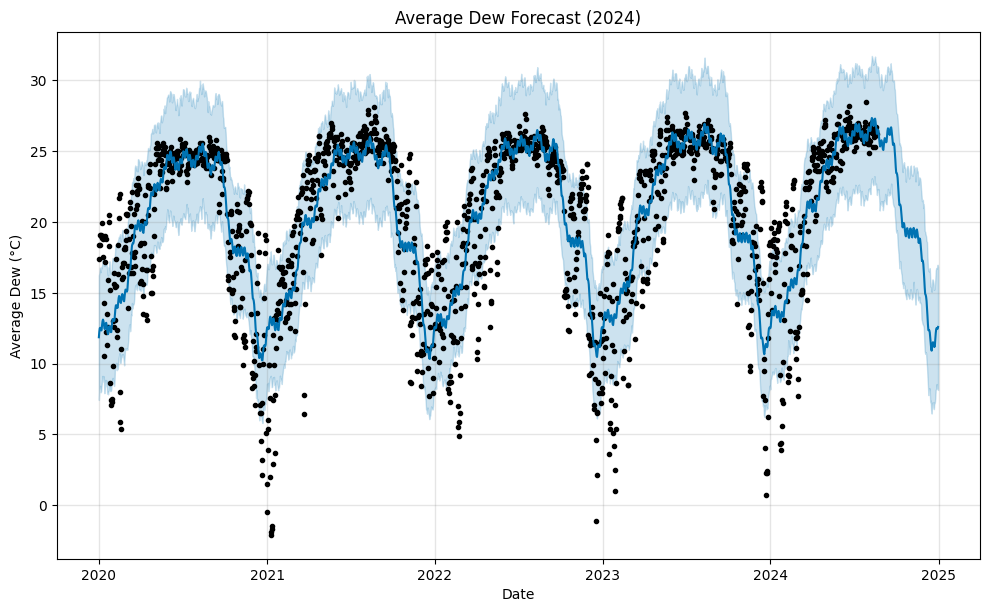

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series cont

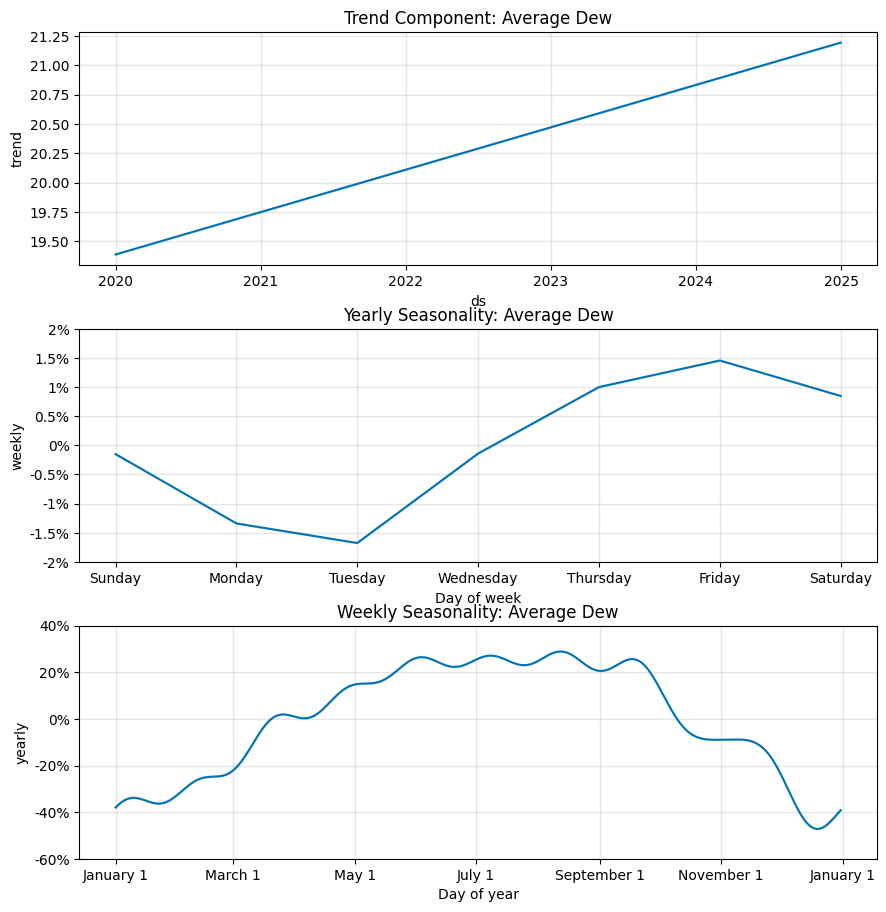

In [1]:
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold
from prophet import Prophet
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
file_path = '../../../dataset/data.csv'
data = pd.read_csv(file_path)

# Prepare the data for Prophet (for Average Dew)
data['ds'] = pd.to_datetime(data['datetime'], format='%m/%d/%Y')
dew_data = data[['ds', 'dew']]  # Rename Average Dew for Prophet
dew_data.rename(columns={'dew': 'y'}, inplace=True)

# Updated parameter grid
param_grid = {
    'changepoint_prior_scale': np.arange(0.01, 0.11, 0.01).tolist(),  # Trend flexibility from 0.01 to 0.1 with step 0.01
    'seasonality_prior_scale': np.arange(0.1, 11, 1.0).tolist(),  # Seasonality flexibility from 0.1 to 10 with step 1.0
    'seasonality_mode': ['additive', 'multiplicative']  # Additive vs multiplicative seasonality
}

# Define number of folds for cross-validation
kf = KFold(n_splits=5)

# Function to evaluate model with given parameters and cross-validation
def evaluate_model_cv(changepoint_prior_scale, seasonality_prior_scale, seasonality_mode, data):
    r2_scores = []
    rmse_scores = []
    mae_scores = []
    
    for train_index, test_index in kf.split(data):
        # Split the data into train and test sets for each fold
        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]
        
        # Initialize the Prophet model with specified hyperparameters
        model = Prophet(
            yearly_seasonality=True,
            changepoint_prior_scale=changepoint_prior_scale,
            seasonality_prior_scale=seasonality_prior_scale,
            seasonality_mode=seasonality_mode
        )
        
        # Fit the model
        model.fit(train_data)
        
        # Predict on the test set (validation set)
        test_forecast = model.predict(test_data[['ds']])
        
        # Calculate R², RMSE, and MAE
        y_true = test_data['y'].values  # Actual Average Dews
        y_pred = test_forecast['yhat'].values  # Predicted Average Dews
        
        r2_scores.append(r2_score(y_true, y_pred))
        rmse_scores.append(mean_squared_error(y_true, y_pred, squared=False))
        mae_scores.append(mean_absolute_error(y_true, y_pred))
    
    # Calculate average scores across the folds
    avg_r2 = np.mean(r2_scores)
    avg_rmse = np.mean(rmse_scores)
    avg_mae = np.mean(mae_scores)
    
    return avg_r2, avg_rmse, avg_mae

# Iterate through the parameter grid and evaluate each combination using K-Fold CV
best_score = -float('inf')
best_params = None
best_rmse = float('inf')
best_mae = float('inf')

for changepoint in param_grid['changepoint_prior_scale']:
    for seasonality_prior in param_grid['seasonality_prior_scale']:
        for seasonality_mode in param_grid['seasonality_mode']:
            print(f"Evaluating: changepoint_prior_scale={changepoint}, seasonality_prior_scale={seasonality_prior}, seasonality_mode={seasonality_mode}")
            r2, rmse, mae = evaluate_model_cv(changepoint, seasonality_prior, seasonality_mode, dew_data)
            print(f"R² Score: {r2:.3f}, RMSE: {rmse:.3f}, MAE: {mae:.3f}\n")
            
            # Keep track of the best model: prioritize highest R², then lowest RMSE and MAE
            if r2 > best_score or (r2 == best_score and rmse < best_rmse and mae < best_mae):
                best_score = r2
                best_rmse = rmse
                best_mae = mae
                best_params = (changepoint, seasonality_prior, seasonality_mode)

# Output the best hyperparameters
print(f"Best R² Score: {best_score:.3f}")
print(f"Best RMSE: {best_rmse:.3f}")
print(f"Best MAE: {best_mae:.3f}")
print(f"Best Hyperparameters: changepoint_prior_scale={best_params[0]}, seasonality_prior_scale={best_params[1]}, seasonality_mode={best_params[2]}")

# Re-train the best model using the entire dataset and best hyperparameters
best_model = Prophet(
    yearly_seasonality=True,
    changepoint_prior_scale=best_params[0],
    seasonality_prior_scale=best_params[1],
    seasonality_mode=best_params[2]
)

best_model.fit(dew_data)

# Generate future dates (from 21/08/2024 to 31/12/2024)
future_dates = best_model.make_future_dataframe(periods=len(pd.date_range('2024-08-21', '2024-12-31')), freq='D')

# Predict future Average Dews
dew_forecast = best_model.predict(future_dates)

# Display and save the predicted Average Dews
dew_forecast[['ds', 'yhat']].tail()
dew_forecast[['ds', 'yhat']].to_csv('dew_forecast_finetuning_2024.csv', index=False)

# Plot the forecasted Average Dews with a title
forecast_plot = best_model.plot(dew_forecast)
plt.title("Average Dew Forecast (2024)")
plt.xlabel("Date")
plt.ylabel("Average Dew (°C)")
plt.show()

# Plot seasonal components (trend, yearly, etc.) with titles
components_plot = best_model.plot_components(dew_forecast)

# Adding titles to individual component plots
ax = components_plot.get_axes()

# Titles for each component
ax[0].set_title('Trend Component: Average Dew')
ax[1].set_title('Yearly Seasonality: Average Dew')
ax[2].set_title('Weekly Seasonality: Average Dew')  # If applicable
plt.show()
